# **NOTEBOOK FOR `ANALYSIS` OF `OULAD` DATA**
***

- ***Goal is to find student dropout factors***

## ***Starting of Analysis***

### ***Data Import, Creating Connection and Checking the data***

In [9]:
import os
from pathlib import Path

def get_project_root(project_name="ranojoy_data_analytics_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

data_path = repo_root / "Beyond Oulad - Students Dropout"
print(data_path)

C:\Users\Rano's PC\Machine\github_repo_cloned\ranojoy_data_analytics_projects\Beyond Oulad - Students Dropout


In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
file_path = data_path / "data" / "processed_data" / "processed_oulad_data.csv"

data = pd.read_csv(file_path)

In [13]:
data.head()

,module,presentation,gender,student_region,qualification,imd_band,age_band,prev_attempts,credits,disability,final_result,registration,unregistration,vle_used,clicks,assessments,attempted_assessment,non_attempted_assessment,score
0,AAA,2013J,M,East Anglia,HE,90-100%,55<=,0,240,N,Stayed,-159.0,NaN,55.0,934.0,5,5,0,82.0
1,AAA,2013J,F,Scotland,HE,20-30%,35-55,0,60,N,Stayed,-53.0,NaN,84.0,1435.0,5,5,0,66.4
2,AAA,2013J,F,North West,A Level,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,22.0,281.0,0,0,0,0.0
3,AAA,2013J,F,South East,A Level,50-60%,35-55,0,60,N,Stayed,-52.0,NaN,82.0,2158.0,5,5,0,76.0
4,AAA,2013J,F,West Midlands,Below A,50-60%,0-35,0,60,N,Stayed,-176.0,NaN,66.0,1034.0,5,5,0,54.4


### ***Initial Data Health Check***

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   module                    32593 non-null  object 
 1   presentation              32593 non-null  object 
 2   gender                    32593 non-null  object 
 3   student_region            32593 non-null  object 
 4   qualification             32593 non-null  object 
 5   imd_band                  31482 non-null  object 
 6   age_band                  32593 non-null  object 
 7   prev_attempts             32593 non-null  int64  
 8   credits                   32593 non-null  int64  
 9   disability                32593 non-null  object 
 10  final_result              32593 non-null  object 
 11  registration              32593 non-null  float64
 12  unregistration            10072 non-null  float64
 13  vle_used                  32593 non-null  float64
 14  clicks

In [15]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 32593
Columns -> 19


In [16]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

,index,null_counts
0,imd_band,1111
1,unregistration,22521


***There are `null` values***

In [9]:
data.duplicated().sum()

np.int64(2)

In [10]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
prev_attempts,32593.0,0.16,0.48,0.0,0.0,0.00,0.0,6.0
credits,32593.0,79.76,41.07,30.0,60.0,60.00,120.0,655.0
registration,32593.0,-69.39,49.23,-322.0,-100.0,-57.00,-29.0,167.0
unregistration,10072.0,49.76,82.46,-365.0,-2.0,27.00,109.0,444.0
vle_used,32593.0,60.15,55.90,0.0,19.0,46.00,86.0,413.0
clicks,32593.0,1215.14,1692.60,0.0,142.0,602.00,1585.0,24139.0
assessments,32593.0,5.34,4.33,0.0,1.0,5.00,9.0,14.0
attempted_assessment,32593.0,5.28,4.34,0.0,1.0,5.00,9.0,14.0
non_attempted_assessment,32593.0,0.06,0.53,0.0,0.0,0.00,0.0,12.0
score,32593.0,57.65,32.93,0.0,43.0,70.57,82.4,100.0


***Knowledge from Initial Healht Check***

- in `date_unregistration` column the value is lower than minimum of `date_registration` which is indicating someone unregistered before registration, need to check that

In [12]:
data[data['unregistration']< data['registration']]

,module,presentation,gender,student_region,qualification,imd_band,age_band,prev_attempts,credits,disability,final_result,registration,unregistration,vle_used,clicks,assessments,attempted_assessment,non_attempted_assessment,score
5356,BBB,2014B,F,West Midlands,Below A,0-10%,0-35,0,120,N,Withdrawn,-57.0,-126.0,0.0,0.0,0,0,0,0.0
5573,BBB,2014B,F,South East,A Level,50-60%,0-35,0,120,N,Withdrawn,-57.0,-142.0,0.0,0.0,0,0,0,0.0
6295,BBB,2014B,F,West Midlands,Below A,60-70%,35-55,4,120,N,Withdrawn,-57.0,-109.0,0.0,0.0,0,0,0,0.0
6305,BBB,2014B,F,North West,Below A,20-30%,0-35,0,150,N,Withdrawn,-57.0,-149.0,0.0,0.0,0,0,0,0.0
8975,CCC,2014B,F,North West,Below A,40-50%,0-35,0,90,Y,Withdrawn,-57.0,-61.0,0.0,0.0,0,0,0,0.0
9811,CCC,2014B,M,West Midlands,A Level,80-90%,0-35,0,120,N,Withdrawn,-57.0,-168.0,0.0,0.0,0,0,0,0.0
9853,CCC,2014B,M,Scotland,Below A,40-50%,0-35,0,60,N,Withdrawn,-57.0,-156.0,0.0,0.0,0,0,0,0.0
10388,CCC,2014B,M,Yorkshire,A Level,70-80%,35-55,0,90,N,Withdrawn,-57.0,-152.0,0.0,0.0,0,0,0,0.0
12545,CCC,2014J,M,North,HE,0-10%,0-35,0,150,N,Withdrawn,-57.0,-65.0,0.0,0.0,0,0,0,0.0
13503,DDD,2013B,M,East Anglia,Below A,30-40%,0-35,0,120,N,Withdrawn,-57.0,-116.0,0.0,0.0,0,0,0,0.0


***There are 2 `duplicated` values***

## **Univariate Analysis of data**

In [12]:
data.describe().round(2)

,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,total_vle_used,total_clicks,total_assessments,attempted_assessment,non_attempted_assessment,average_score
count,32593.00,32593.00,32593.00,10072.00,32593.00,32593.00,32593.0,32593.0,32593.0,32593.00
mean,0.16,79.76,-69.39,49.76,60.15,1215.14,5.34,5.28,0.06,57.65
std,0.48,41.07,49.23,82.46,55.90,1692.60,4.33,4.34,0.53,32.93
min,0.00,30.00,-322.00,-365.00,0.00,0.00,0.0,0.0,0.0,0.00
25%,0.00,60.00,-100.00,-2.00,19.00,142.00,1.0,1.0,0.0,43.00
50%,0.00,60.00,-57.00,27.00,46.00,602.00,5.0,5.0,0.0,70.57
75%,0.00,120.00,-29.00,109.00,86.00,1585.00,9.0,9.0,0.0,82.40
max,6.00,655.00,167.00,444.00,413.00,24139.00,14.0,14.0,12.0,100.00


### ***Statistical Insight from numerical columns***

- `studied_credits` ranges from 30 to 655

- `date_registration` ranges from -322 to 176

- `date_unregistration` ranges from -365 to 444

- `total_vle_used` ranges from 0 to 413

- `total_clicks` ranges from 0 to 24139

- `average_score` ranges from 0 to 100

In [13]:
data.describe(include='object')

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result
count,32593,32593,32593,32593,32593,31482,32593,32593,32593
unique,7,4,2,13,5,10,3,2,4
top,BBB,2014J,M,Scotland,A Level or Equivalent,20-30%,0-35,N,Pass
freq,7909,11260,17875,3446,14045,3654,22944,29429,12361


### ***Statistical insight from categorical column***

- `region` have 13 unique values

In [14]:
data.select_dtypes(include='number').nunique().reset_index(name = 'total_unique_values')

,index,total_unique_values
0,num_of_prev_attempts,7
1,studied_credits,61
2,date_registration,332
3,date_unregistration,416
4,total_vle_used,325
5,total_clicks,5381
6,total_assessments,15
7,attempted_assessment,15
8,non_attempted_assessment,13
9,average_score,2601


In [15]:
data.select_dtypes(include='number').columns

Index(['num_of_prev_attempts', 'studied_credits', 'date_registration',
       'date_unregistration', 'total_vle_used', 'total_clicks',
       'total_assessments', 'attempted_assessment', 'non_attempted_assessment',
       'average_score'],
      dtype='object')

In [16]:
data.select_dtypes(include='object').nunique().reset_index(name = 'total_unique_values')

,index,total_unique_values
0,code_module,7
1,code_presentation,4
2,gender,2
3,region,13
4,highest_education,5
5,imd_band,10
6,age_band,3
7,disability,2
8,final_result,4


In [17]:
small_cat_cols = ['code_module', 'code_presentation', 'gender',
       'highest_education', 'imd_band', 'age_band', 'disability','num_of_prev_attempts']

In [18]:
large_num_cols = [ 'studied_credits', 'date_registration',
       'date_unregistration', 'total_vle_used', 'total_clicks','total_assessments', 'attempted_assessment', 'non_attempted_assessment',
       'average_score']

In [19]:
large_cat_cols = ['region']

In [20]:
target_col = ['final_result']

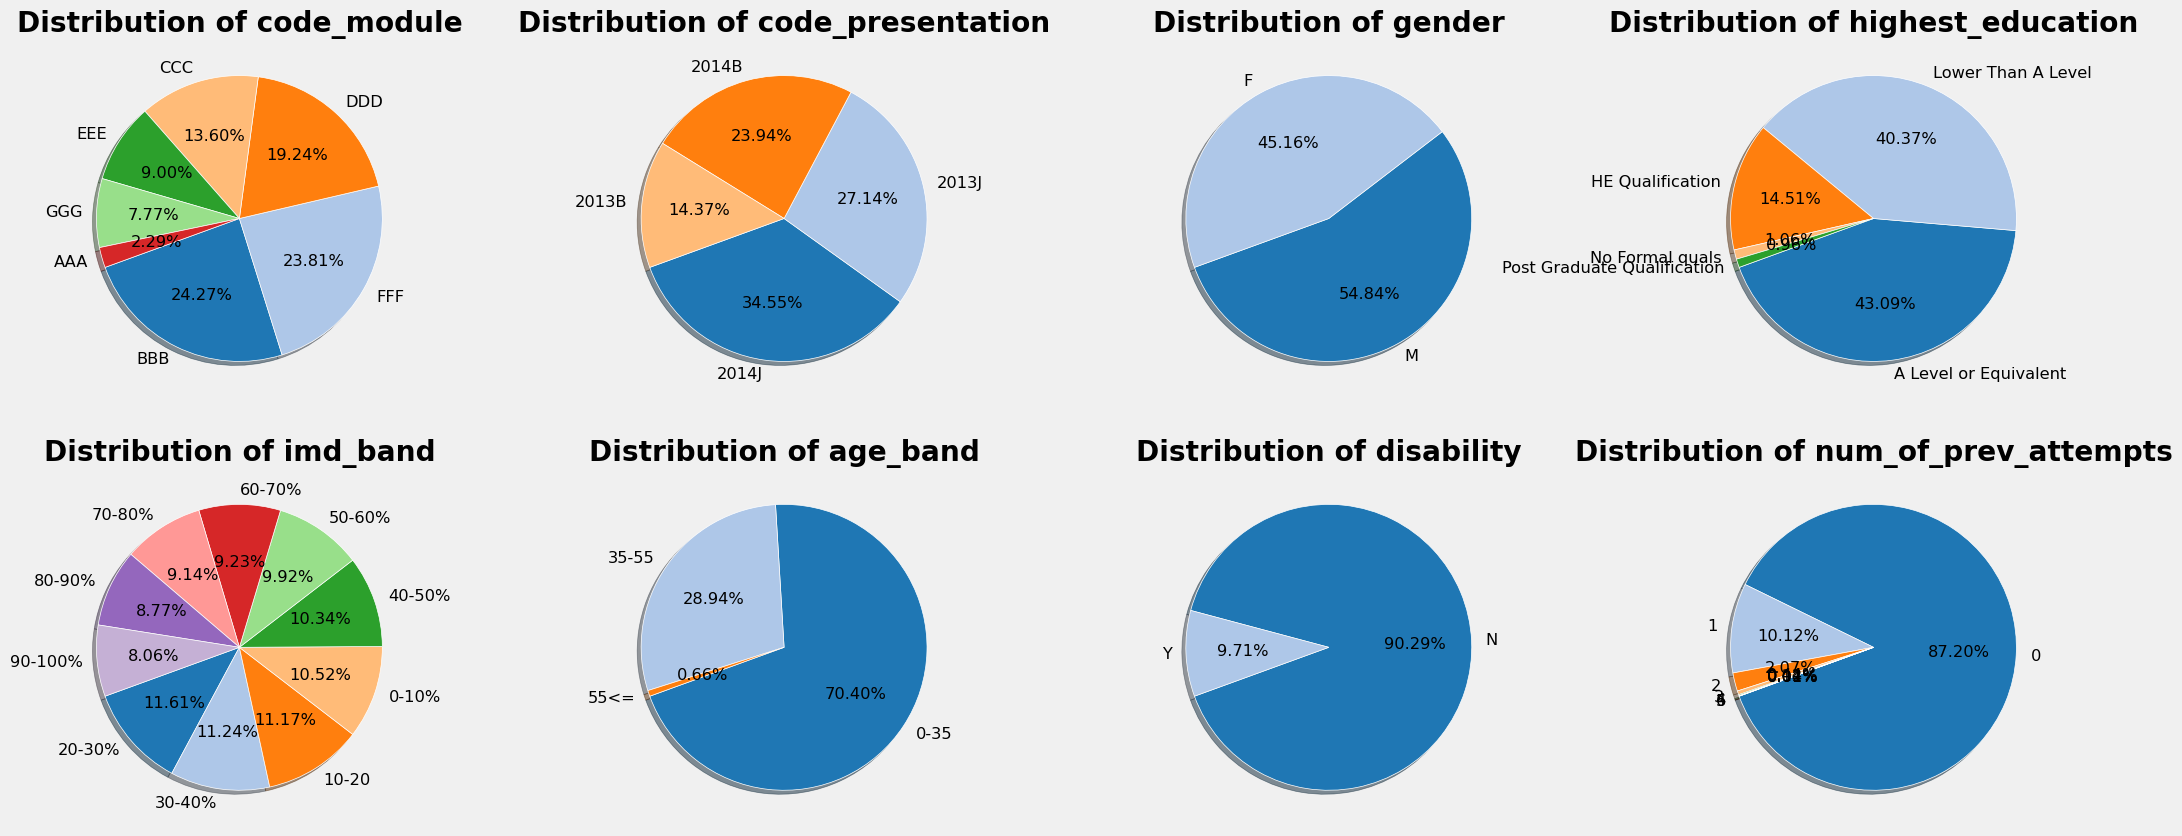

In [21]:
fig = plt.figure(figsize=(24,15))
limit = len(small_cat_cols)
for i,column in enumerate(small_cat_cols):
    if i> limit:
        break
    plt.subplot(3,4,i+1)
    P.plot_pie(column=column,data=data)

### ***Insights from univariate analysis of small classed categorical columns***

- `BBB` and `FFF` have the most occurances in `course_module` column and `AAA` have the least occurances

- `2014J` have the most occurance in `code_presentation` column

- `M` have slighly more occurances than `F` in gender column

- `highest_education` column have `5` unique values and `post graduation` and `no formal` eduation occurs least of the time

- `imd_band` column is distributed almost equally in all classes, having `3.41%` of occurances as `unknown`

- `0-35` age band have the highest occurance in `age_band` column with least occurance of `55+` age bands

- more than `90%` of occurances have `N` in disability column


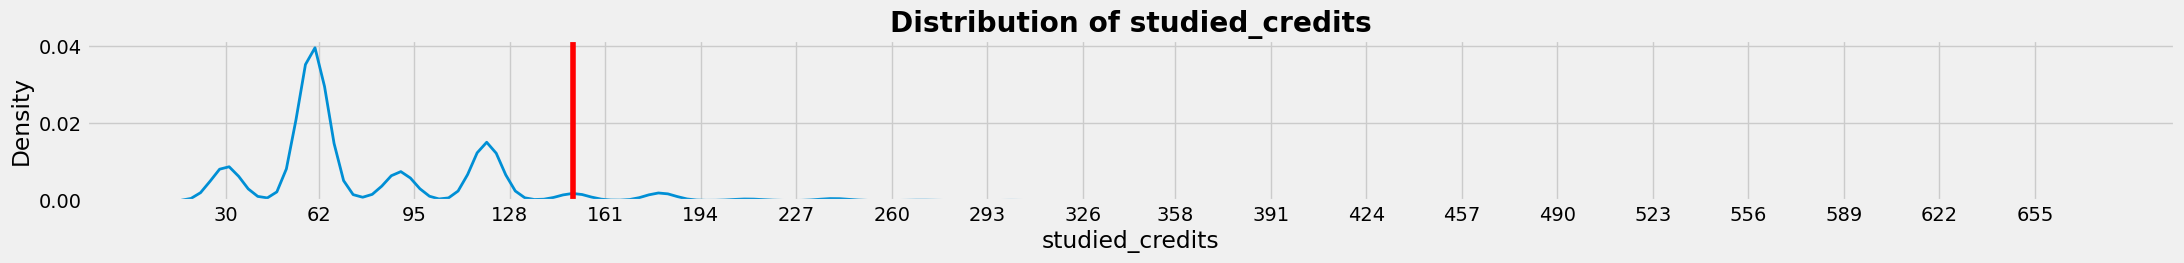

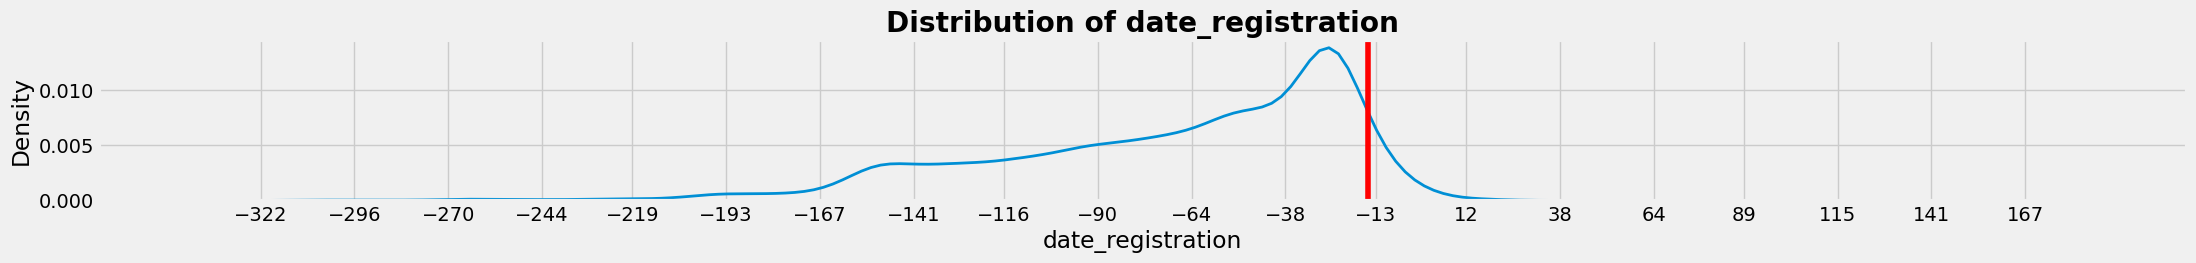

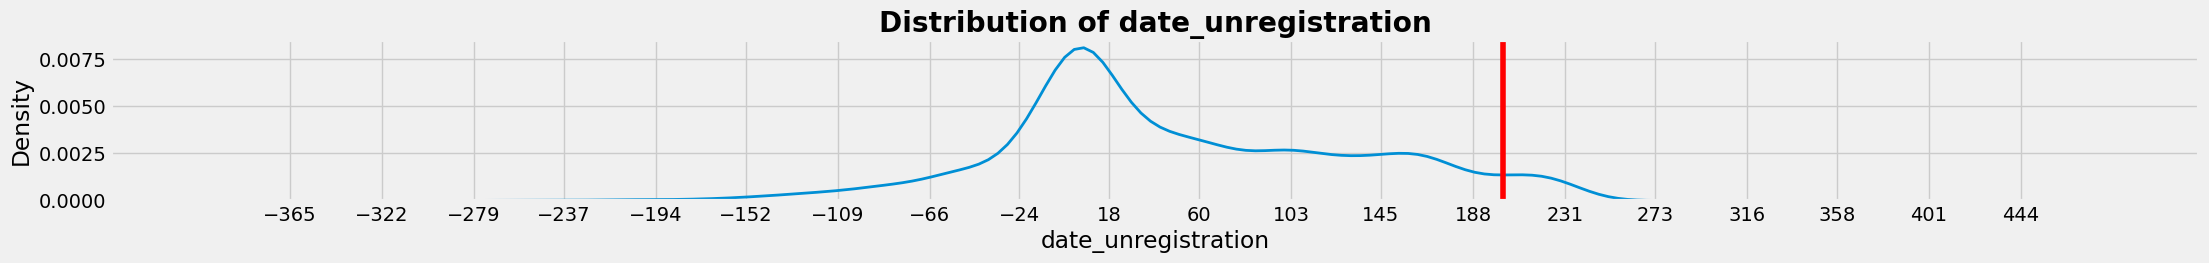

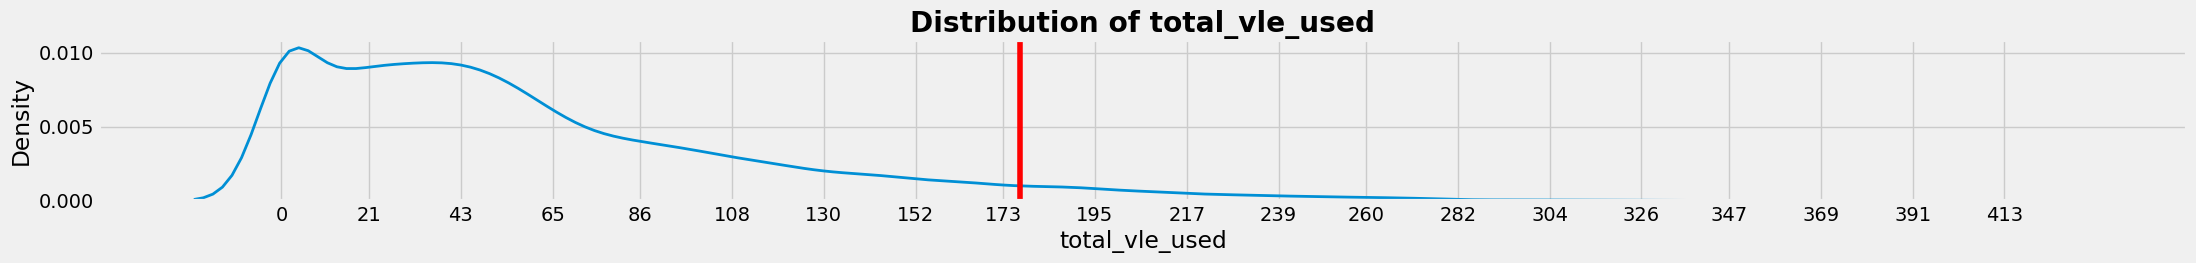

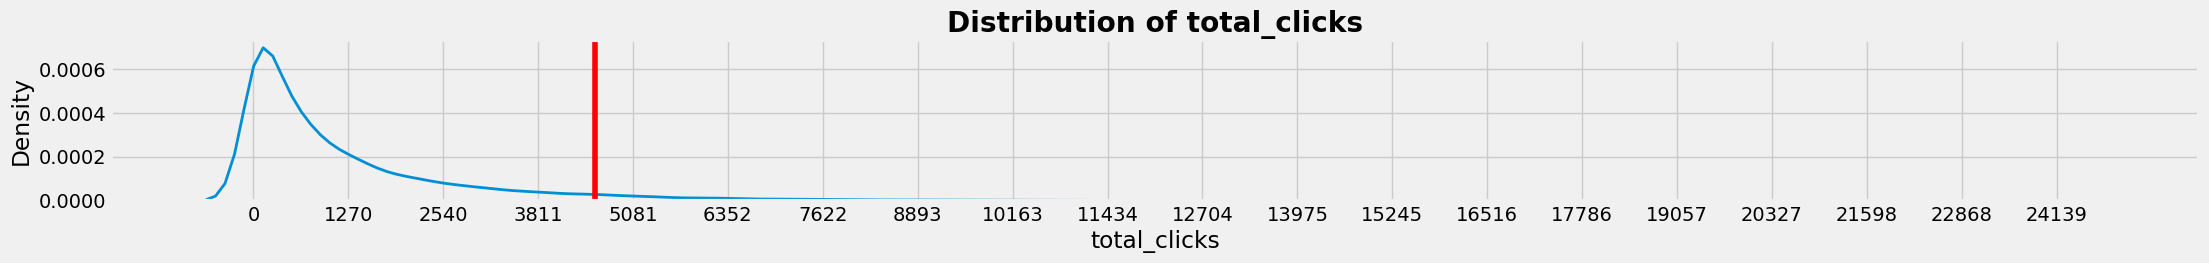

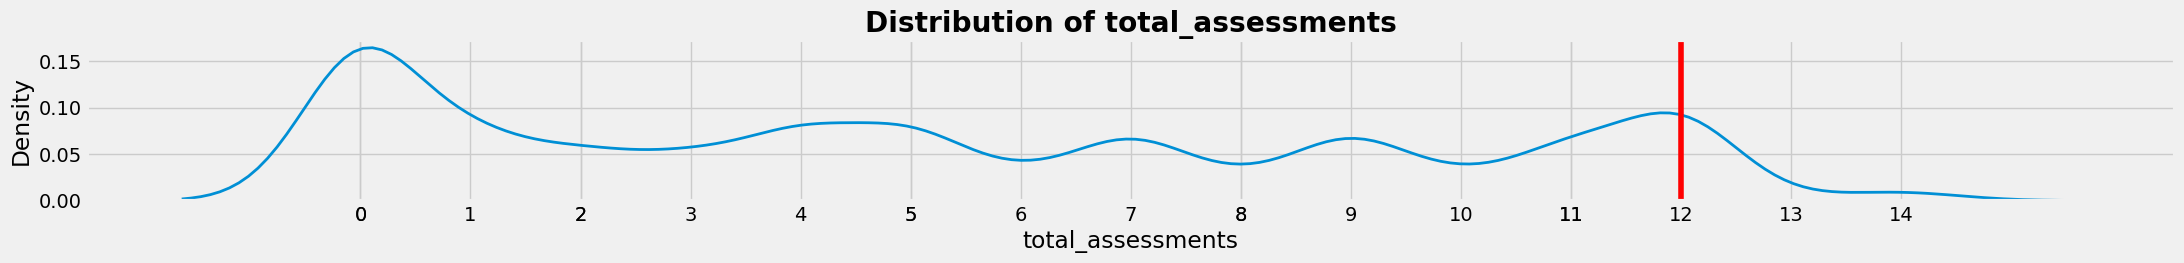

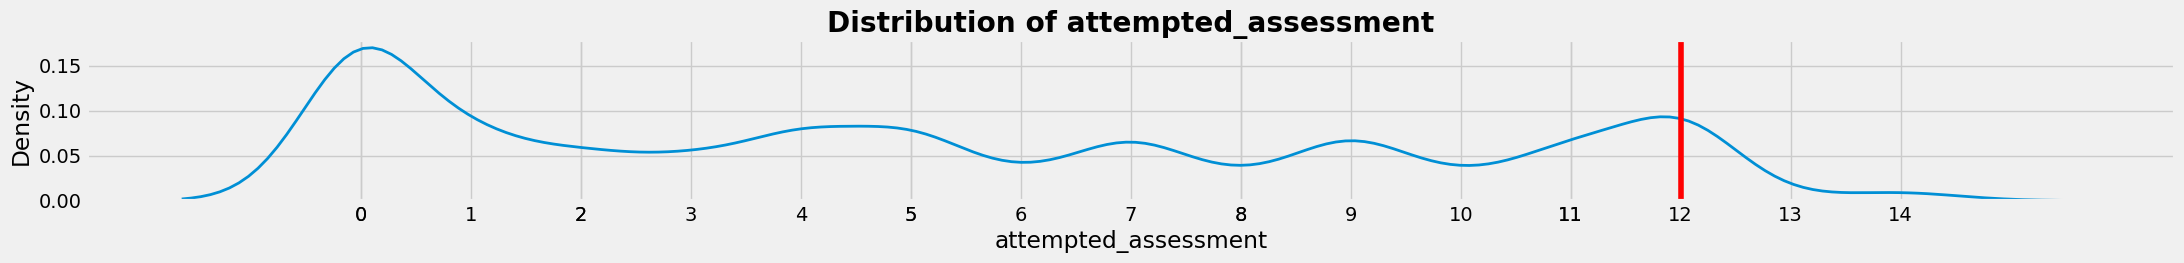

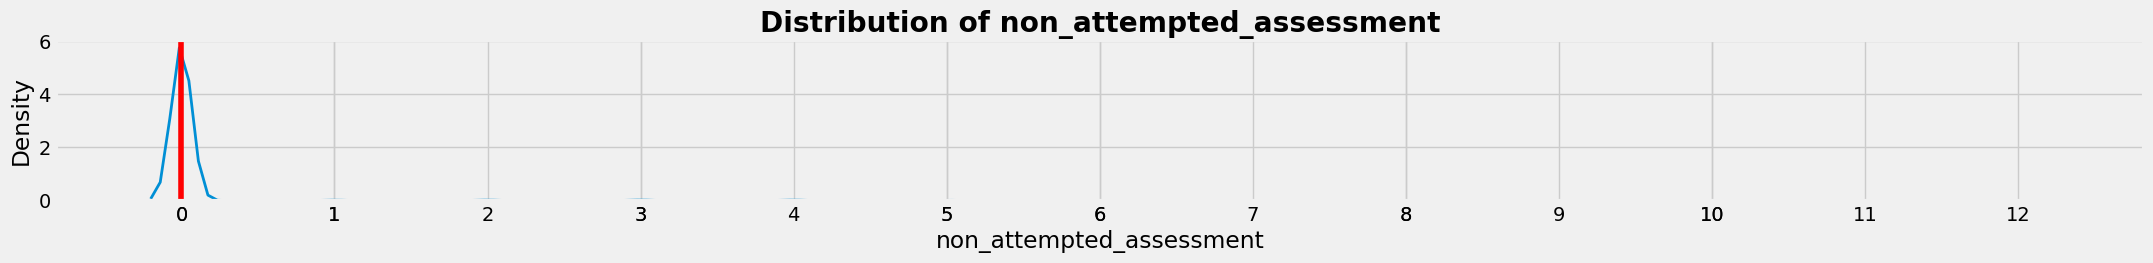

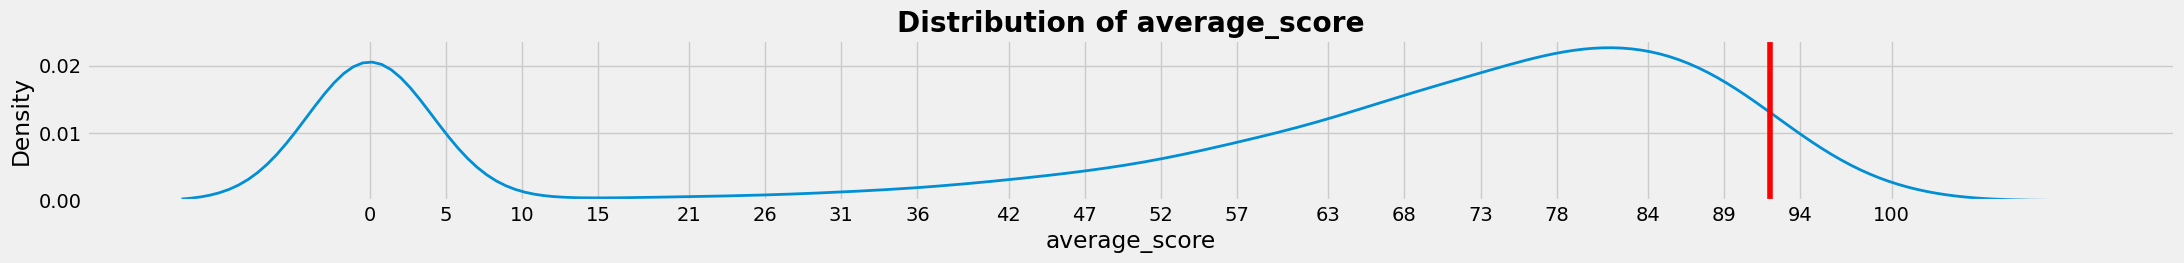

In [22]:
limit = len(large_num_cols)
for i,column in enumerate(large_num_cols):
    if i> limit:
        break
    fig = plt.figure(figsize=(24,21))
    plt.subplot(9,1,i+1)
    P.plot_kde(column=column,data=data)
    plt.show()

### ***Insights from univariate analysis of numerical columns***

- most of the values of `number_of_previous_attempts` column is around `0`

- `studied_credit` column is skewed towards right with most values around the median

- `date_registration` column have a peak before 0

- `date_unregistration` column vales peaks around 0

- `total_vle_used` column is skewed towrds the bigger side

- `total_clicks` column is heavily skewed to the bigger side with more values near 0

- `total_assessment` column is someway uniformly distributed with more values around 0

- `attempted_assessment` follows same distribution as total_assessment

- `non_attempted_assessment` is skewed towards right with more values around 0

- `average_score` have 2 peaks one at bigger end and one at 0

In [23]:
for cols in large_cat_cols:
    df = data[cols].value_counts(normalize=True).mul(100).round(2).reset_index(name = r"% of observations").sort_values(by ="% of observations", ascending = False ).head(10)
    display(df)
    display("_"*50)

,region,% of observations
0,Scotland,10.57
1,East Anglian Region,10.25
2,London Region,9.87
3,South Region,9.49
4,North Western Region,8.92
5,West Midlands Region,7.92
6,South West Region,7.47
7,East Midlands Region,7.26
8,South East Region,6.48
9,Wales,6.40


'__________________________________________________'

### ***Insights from univariate analysis of large categorical columns***

- `region` column is divided into `13` classes and `scotland` occured most of the times

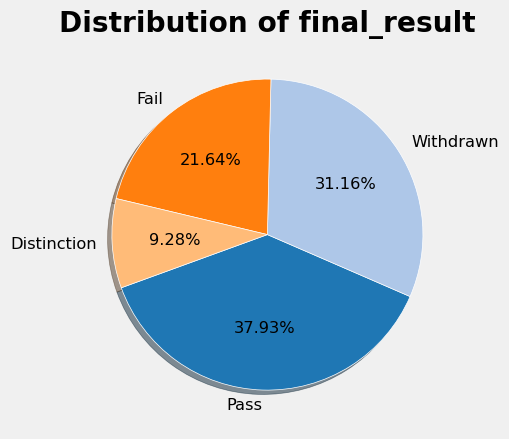

In [24]:
P.plot_pie('final_result',data=data)

### ***Insight from univariate analysis of target column***

- `31%` of occurances are withdrawn in the `final_result` column

***

## **Bivariate Analysis with `final_result` column**

### **Categorical Columns with small sub-caetgories with target**

In [25]:
small_cat_cols

['code_module',
 'code_presentation',
 'gender',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'num_of_prev_attempts']

**code_module**

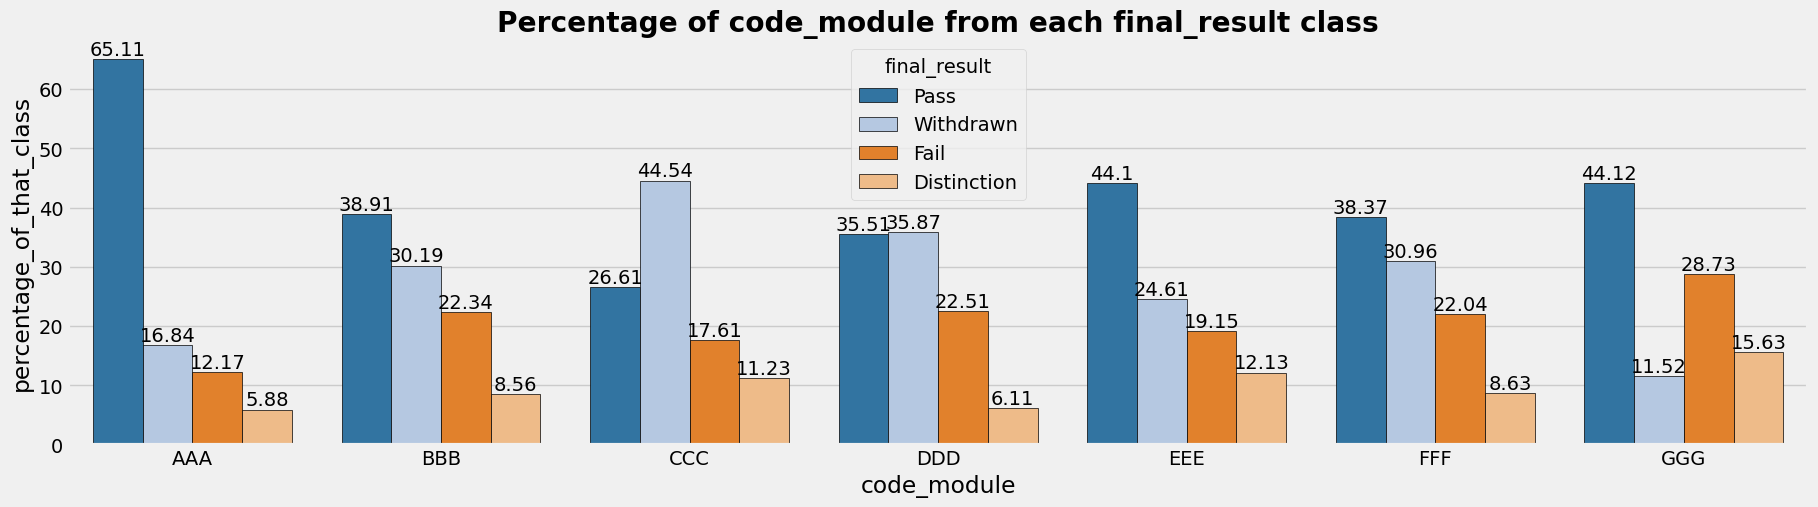

In [26]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='code_module',data=data,target='final_result',orient='v')

**code module ccc is showing high percentage of withdrawn students**

In [27]:
code_module_mask = (data['code_module']=='CCC')
ct = pd.crosstab(code_module_mask,data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.127 → Moderate


**code module has moderate relationship with target column**

***

**code_presentation**

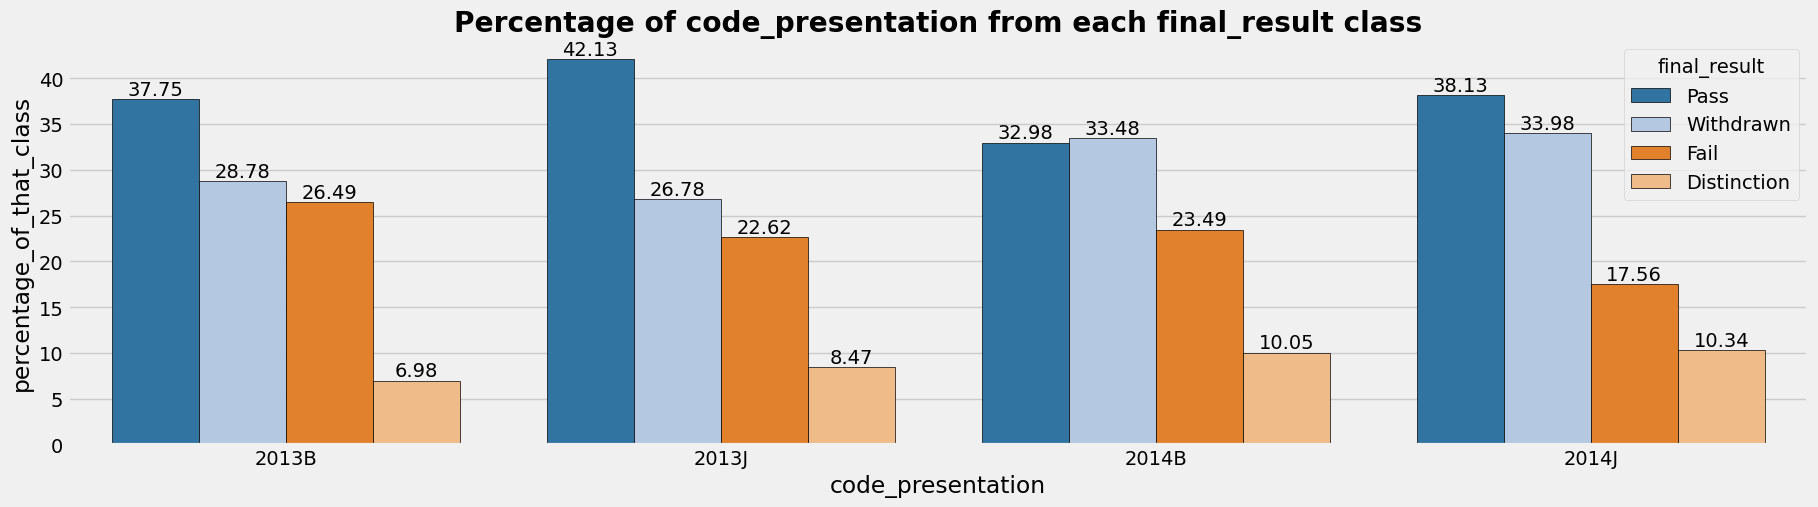

In [28]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='code_presentation',data=data,target='final_result',orient='v')

**no strong relationship found**

***

**gender**

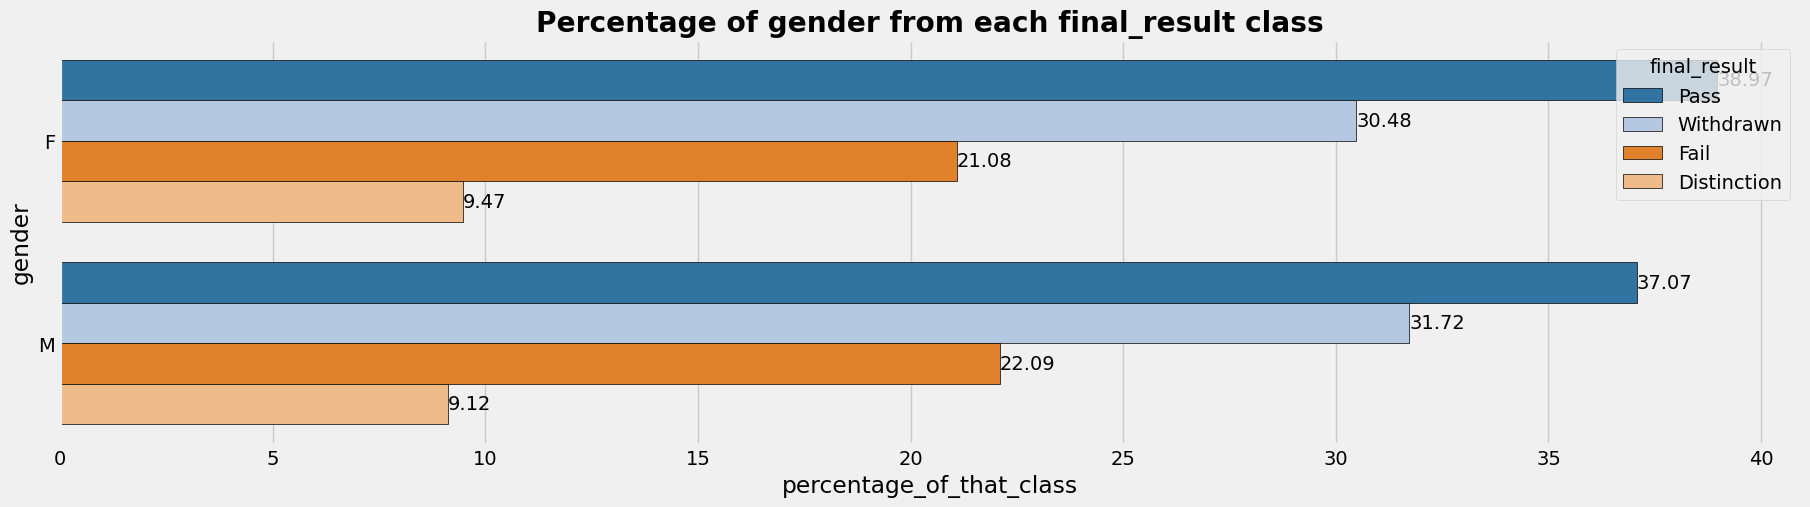

In [29]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='gender',data=data,target='final_result',orient='h')

**No strong difference found between classes**

***

**highest education**

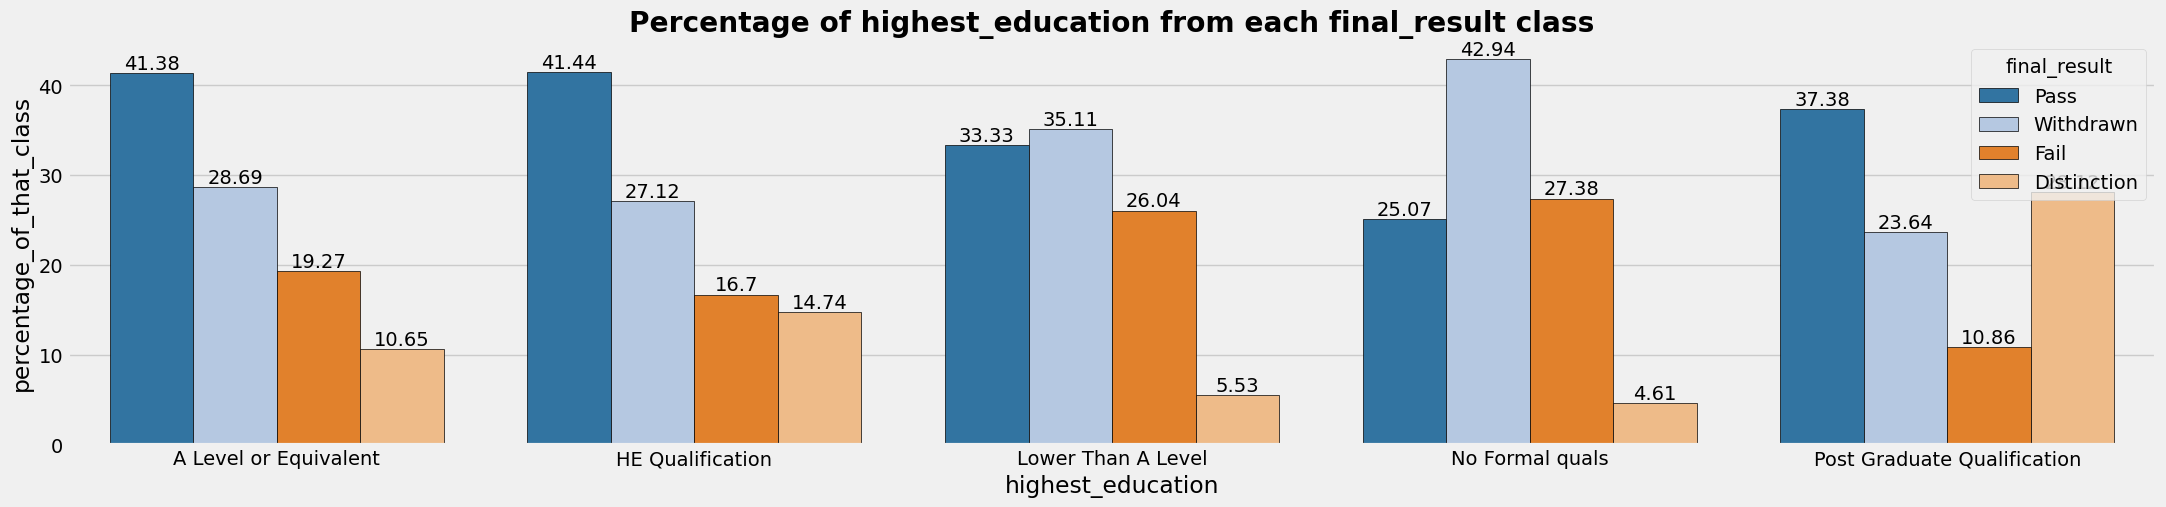

In [30]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='highest_education',data=data,target='final_result',orient='v')

**No formal quals and lower than a level is showing high percentage of withdrawls**

In [31]:
highest_education_mask = (data['highest_education']=='Lower Than A Level') | (data['highest_education']=='No Formal quals')
ct = pd.crosstab(highest_education_mask,data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.160 → Moderate


**higest education holds moderate relationship with final result column**

***

**imd_band**

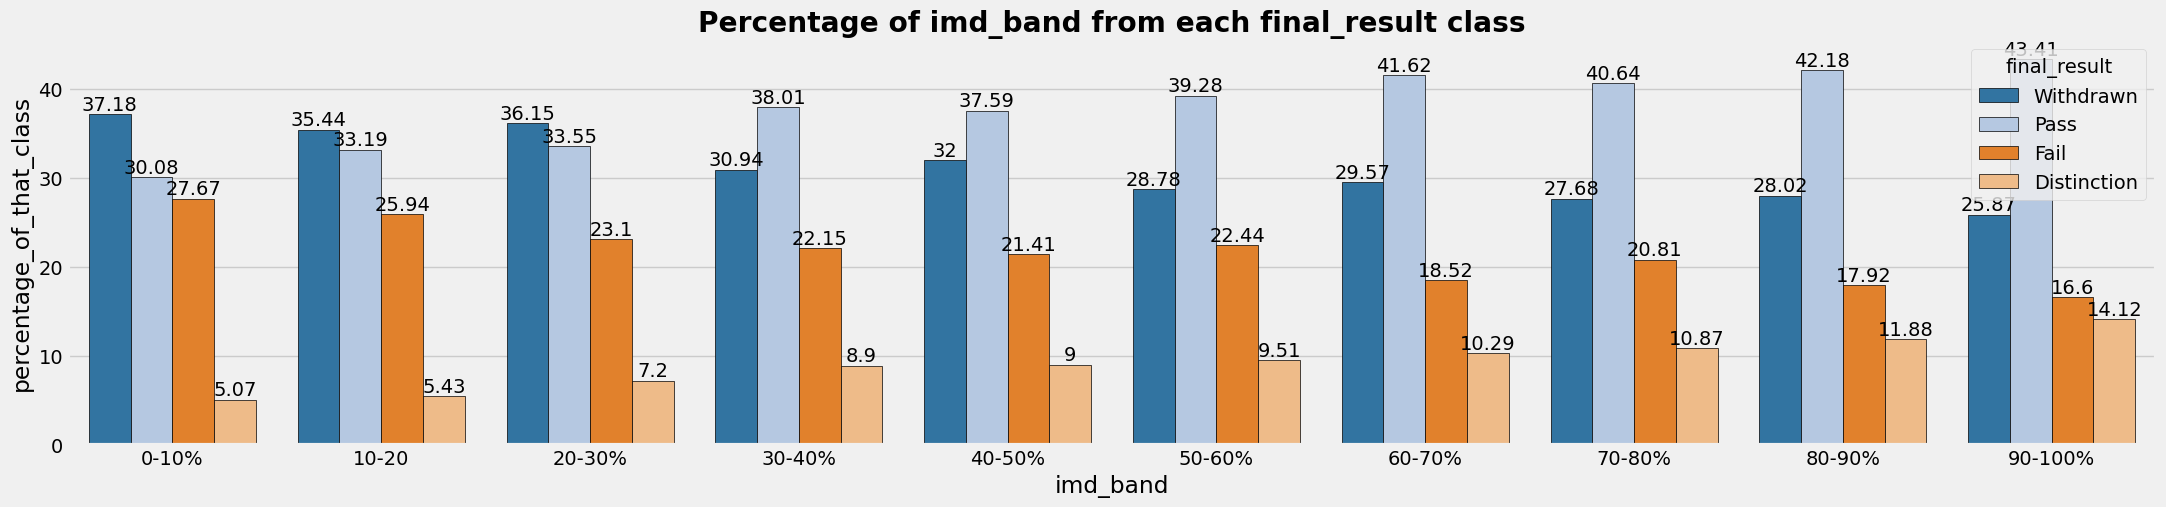

In [32]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='imd_band',data=data,target='final_result',orient='v')

In [33]:
ct = pd.crosstab(data['imd_band'],data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.084 → Weak


**imd_band have weak relationship with final result**

***

**age_band**

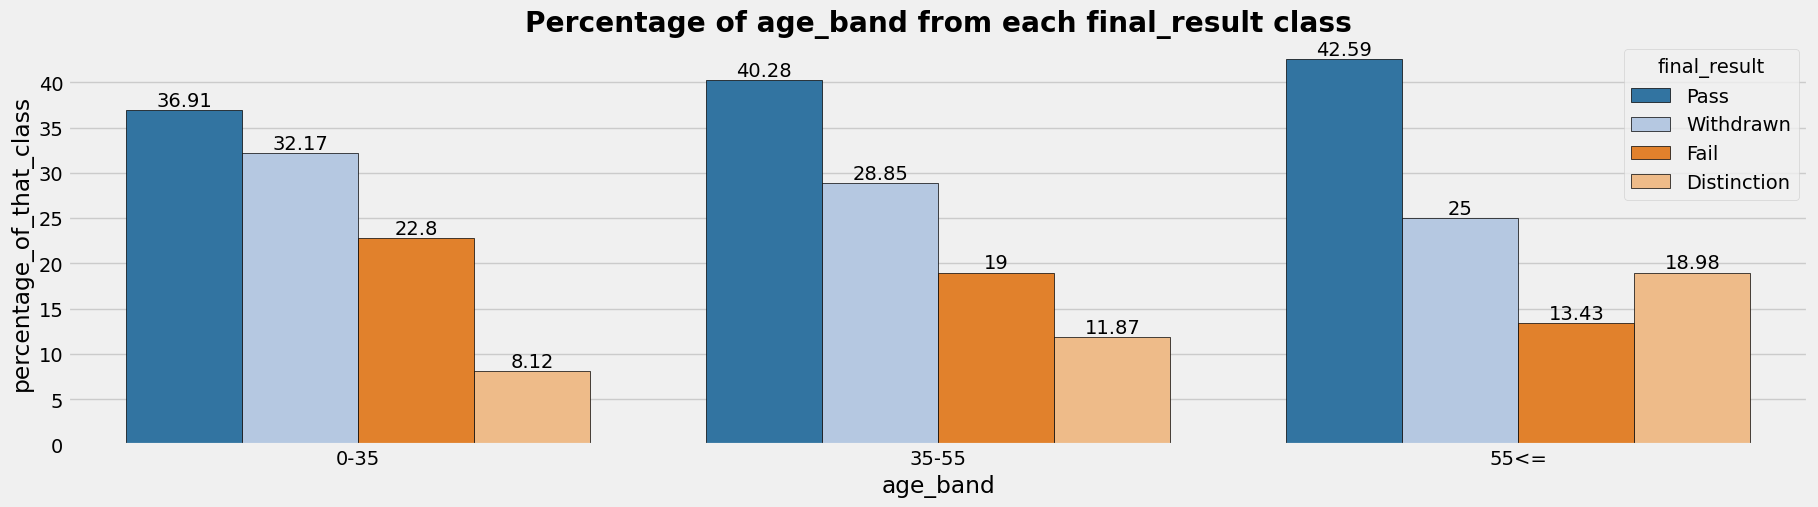

In [34]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='age_band',data=data,target='final_result',orient='v')

In [35]:
ct = pd.crosstab(data['age_band'],data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.058 → Weak


**age band have weak relationship with final result**

***

**disability**

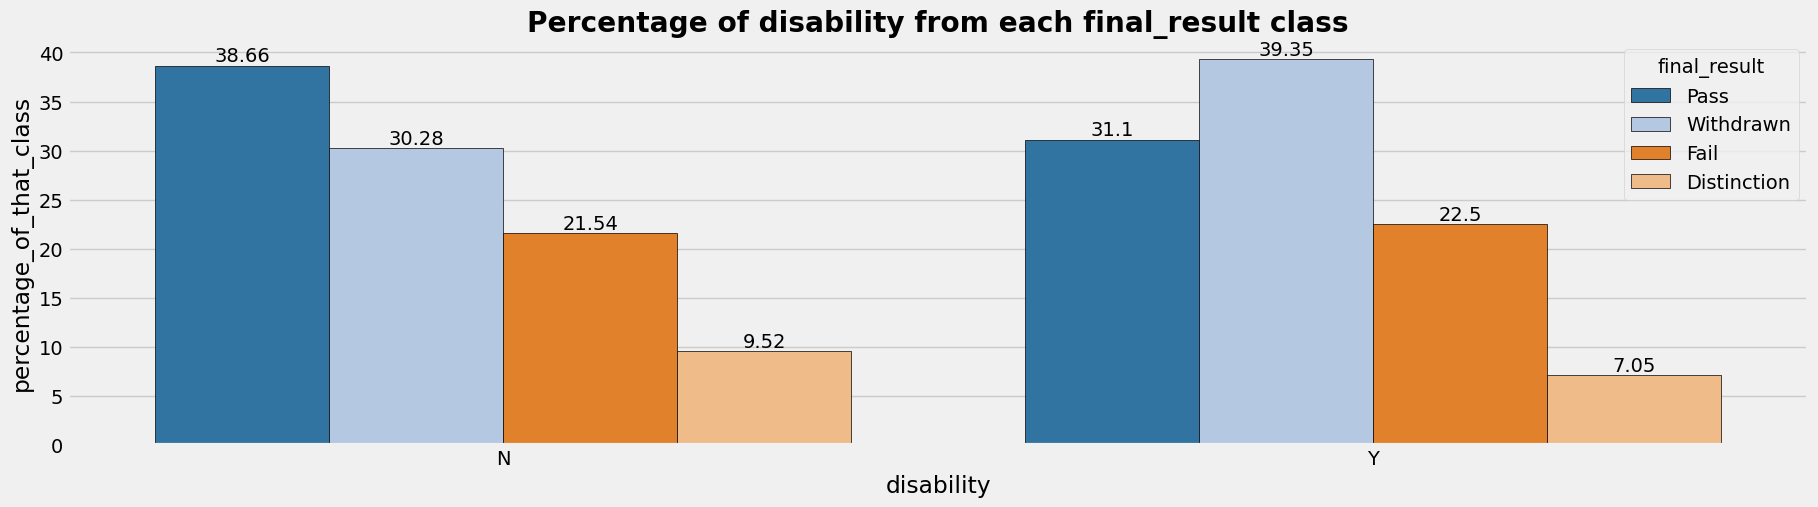

In [36]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='disability',data=data,target='final_result',orient='v')

In [37]:
ct = pd.crosstab(data['disability'],data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.065 → Weak


**disability have weak relationship with final_result**

***

### **Numerical Column with `final_result`**

**studied credits**

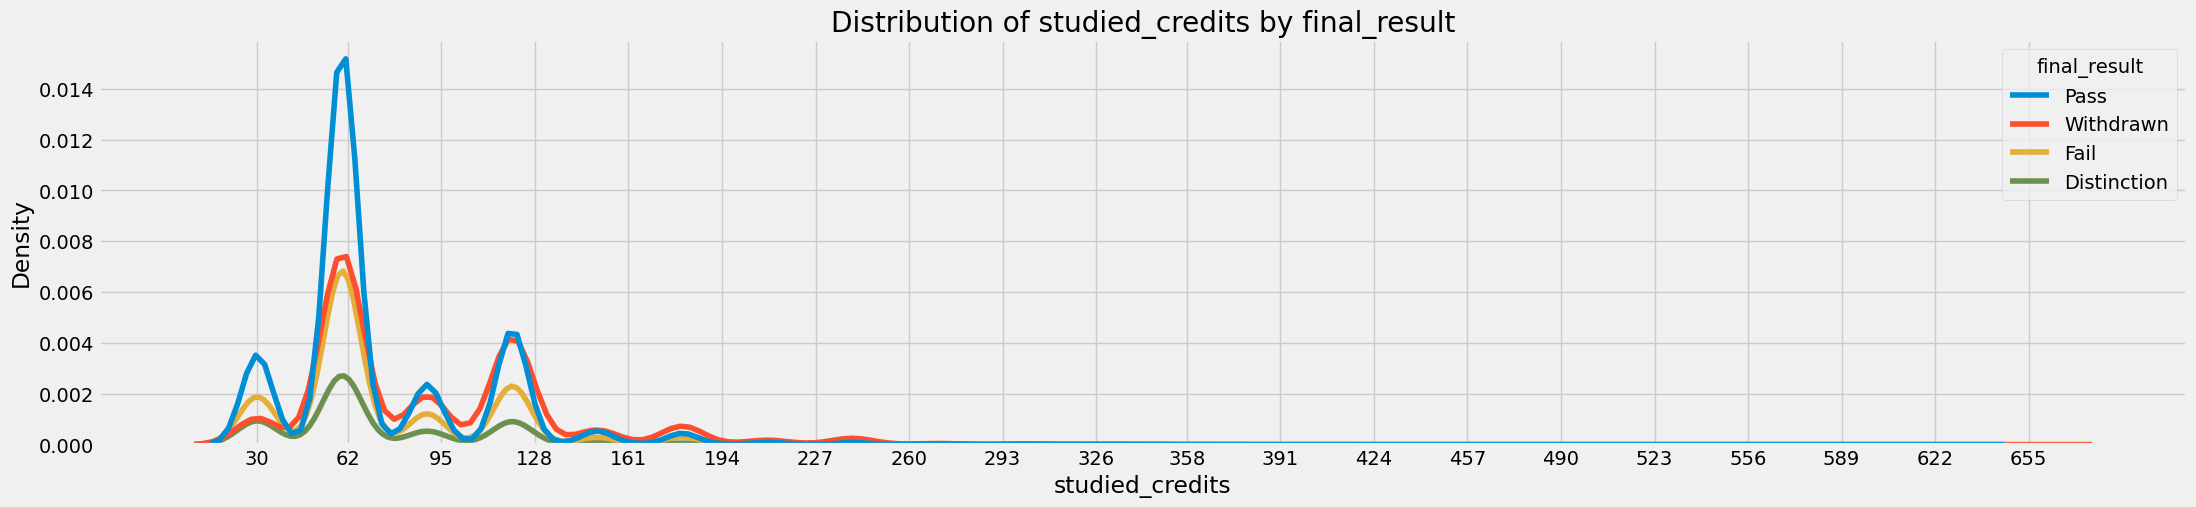

In [38]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='studied_credits',data= data,target='final_result')

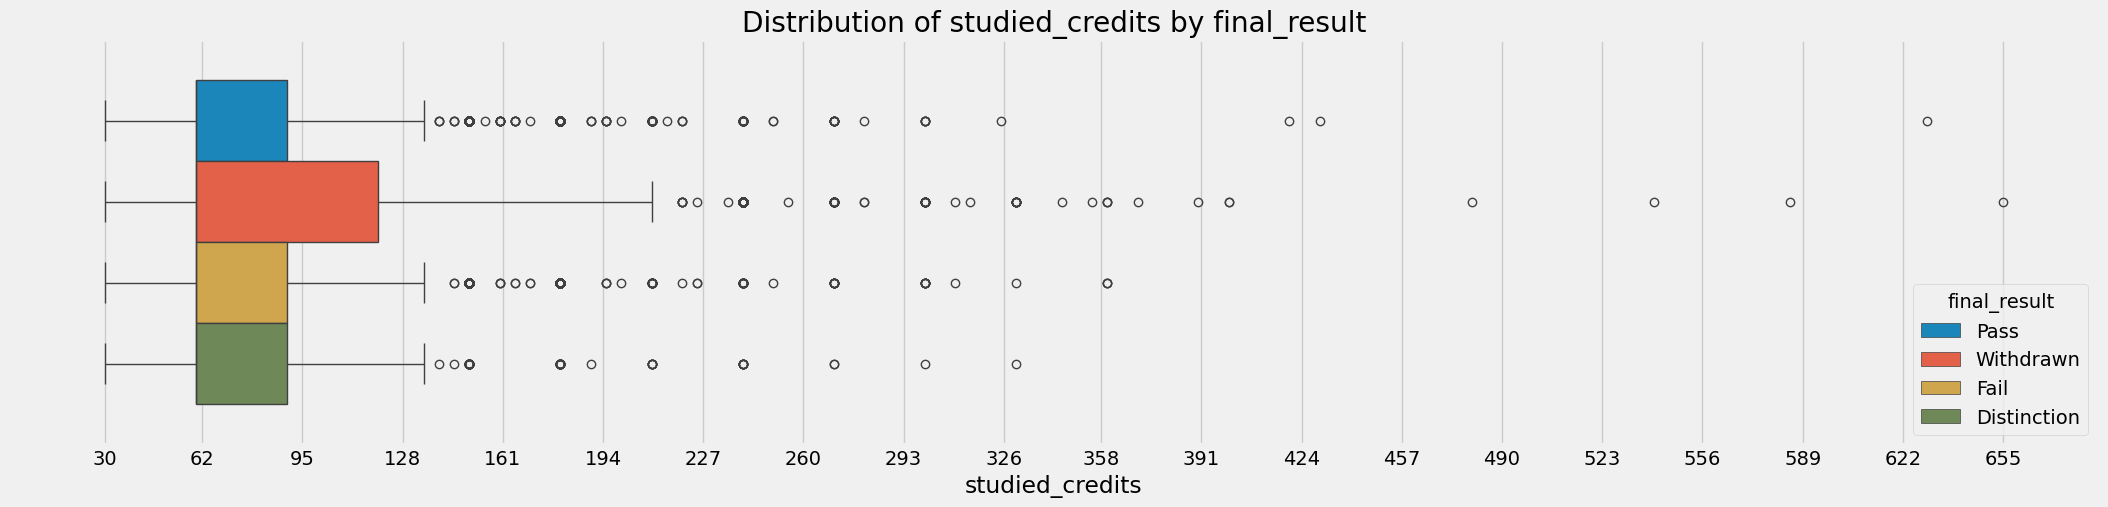

In [39]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='studied_credits',data= data,target='final_result')

In [40]:
data.groupby('final_result')['studied_credits'].mean().round(2)

final_result
Distinction    71.76
Fail           76.09
Pass           74.22
Withdrawn      91.43
Name: studied_credits, dtype: float64

**average studied credit showing high mean compared to others for withdrawn candidates**

In [41]:
S.numerical_test(data,'final_result','studied_credits','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: weak


**groups are different in studied_credits, but strength is weak**

***

**num_of_prev_attempts**

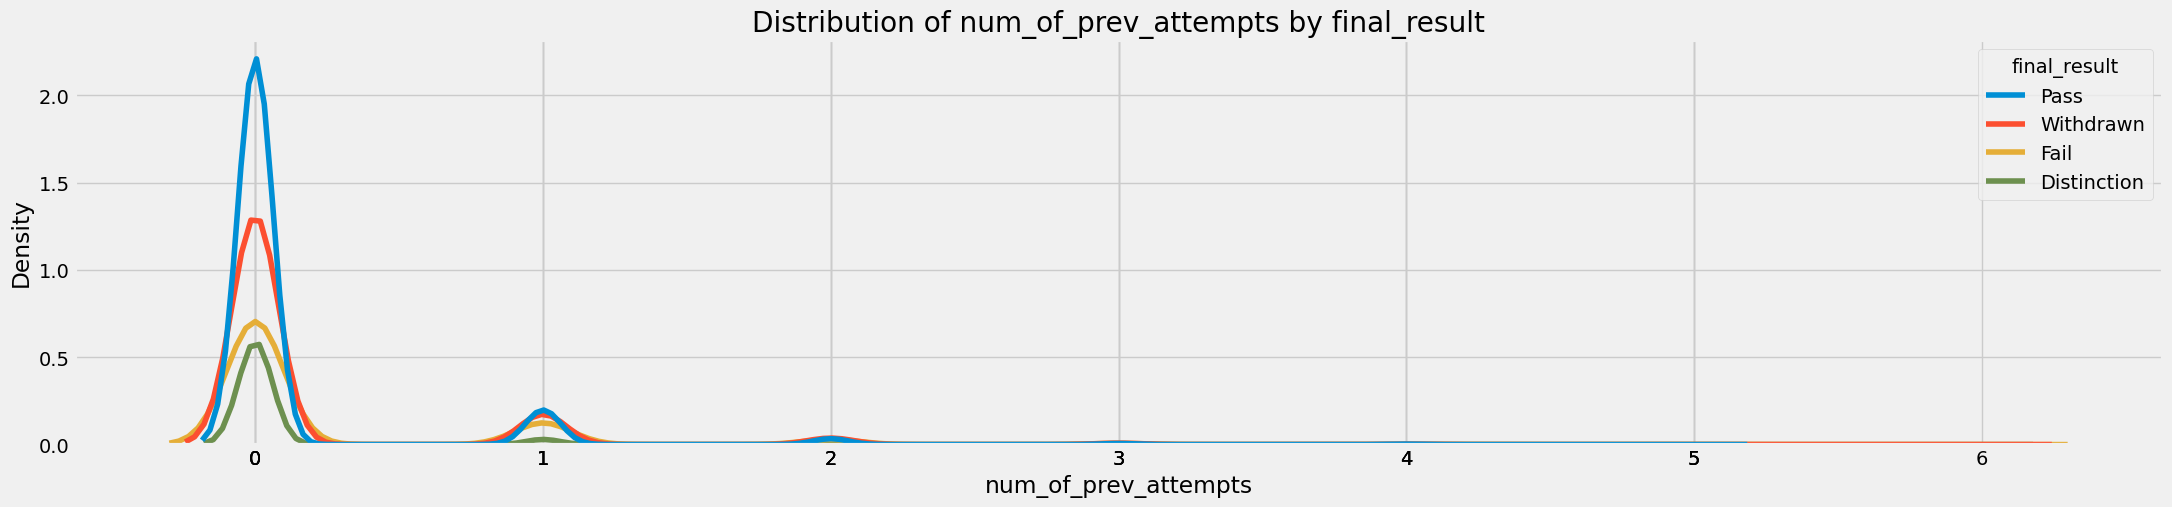

In [42]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='num_of_prev_attempts',data= data,target='final_result')

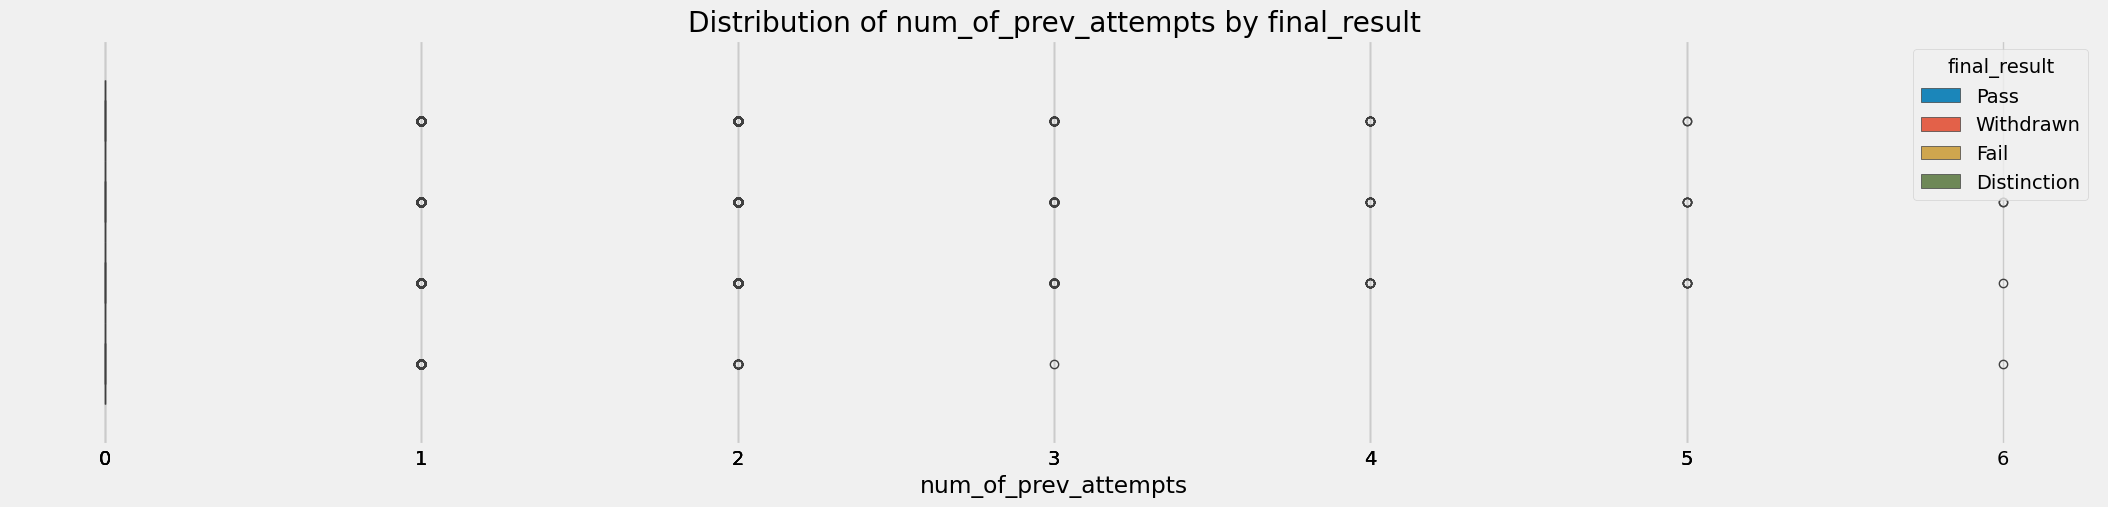

In [43]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='num_of_prev_attempts',data= data,target='final_result')

In [44]:
data.groupby('final_result')['num_of_prev_attempts'].mean().round(2)

final_result
Distinction    0.06
Fail           0.25
Pass           0.12
Withdrawn      0.19
Name: num_of_prev_attempts, dtype: float64

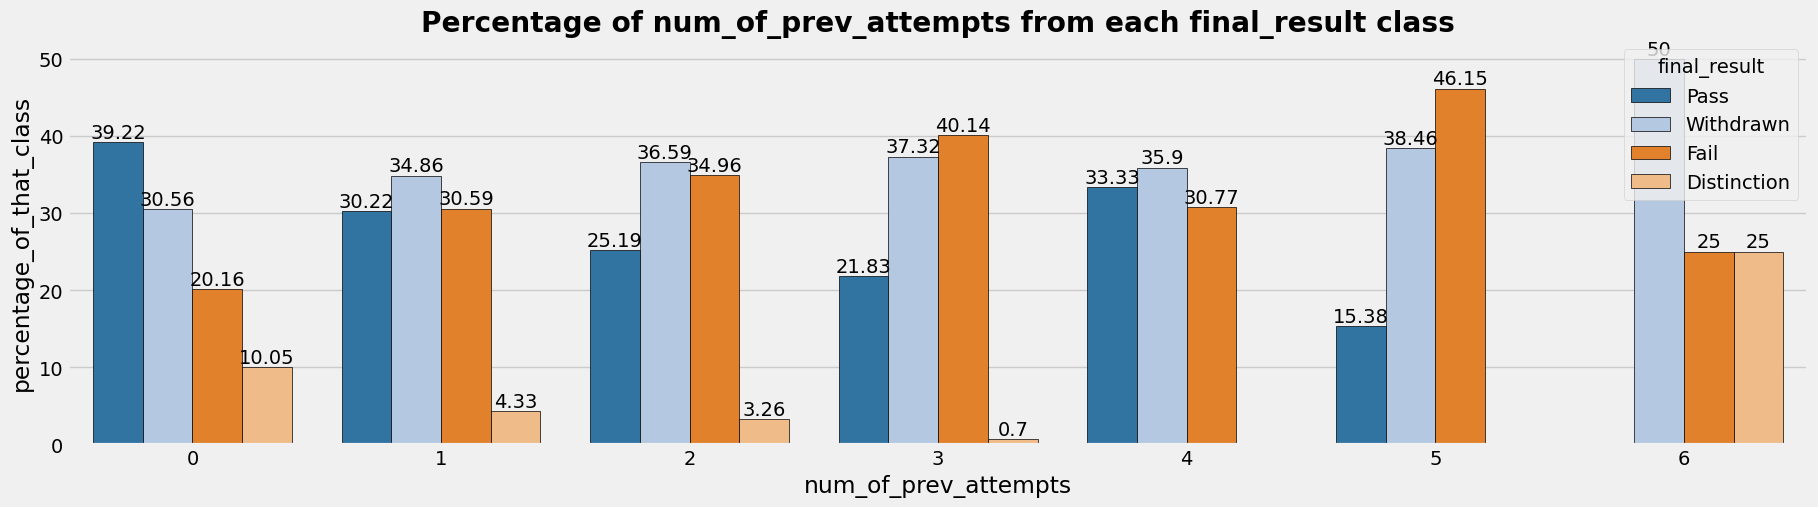

In [45]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='num_of_prev_attempts',data=data,target='final_result',orient='v')

**num of previous attempt is showing higher the attempts, more of the chance of readmission**

In [46]:
ct = pd.crosstab(data['num_of_prev_attempts'],data['final_result'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.073 → Weak


**althoug num_of_prev_attempts have weak relationship with target column**

***

**date_registration**

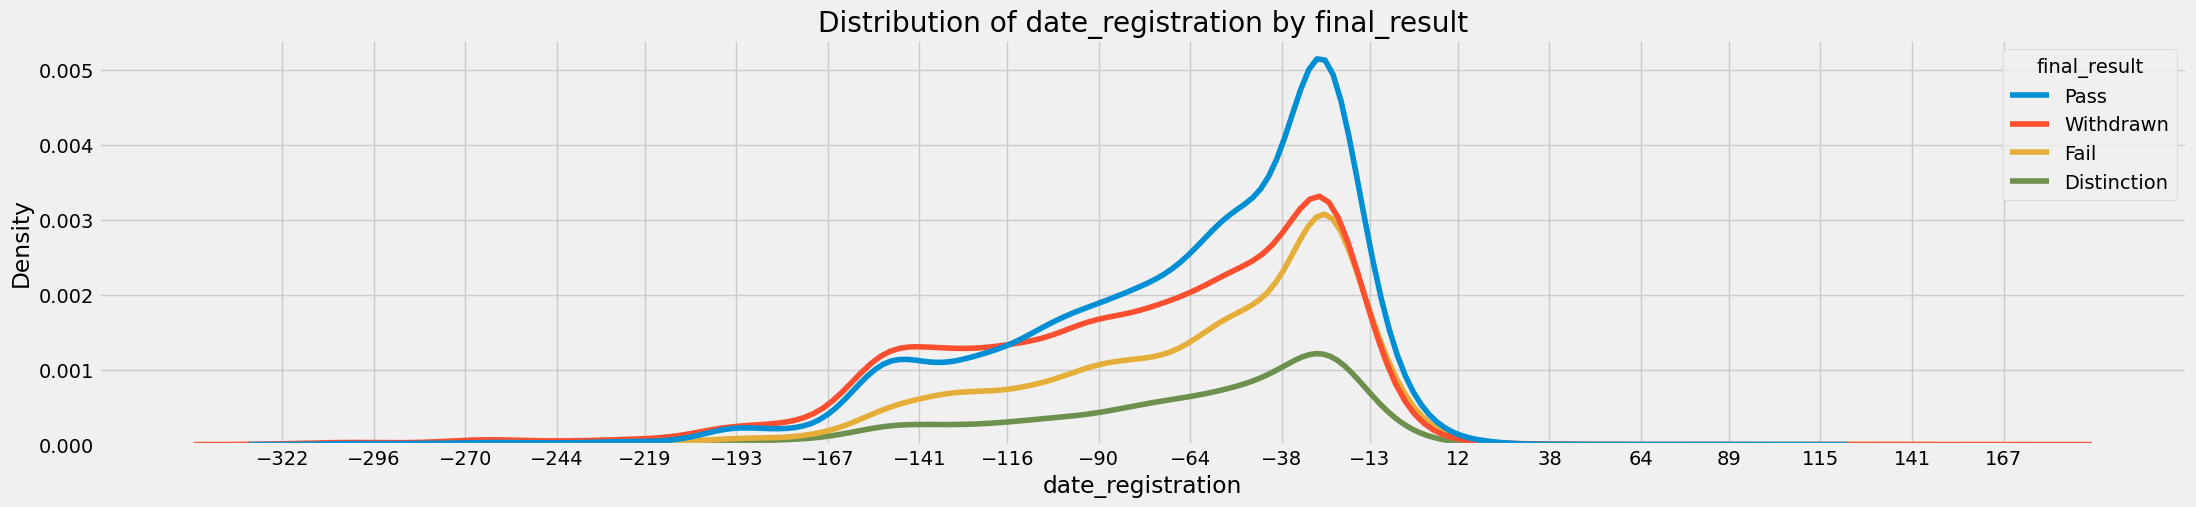

In [47]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='date_registration',data= data,target='final_result')

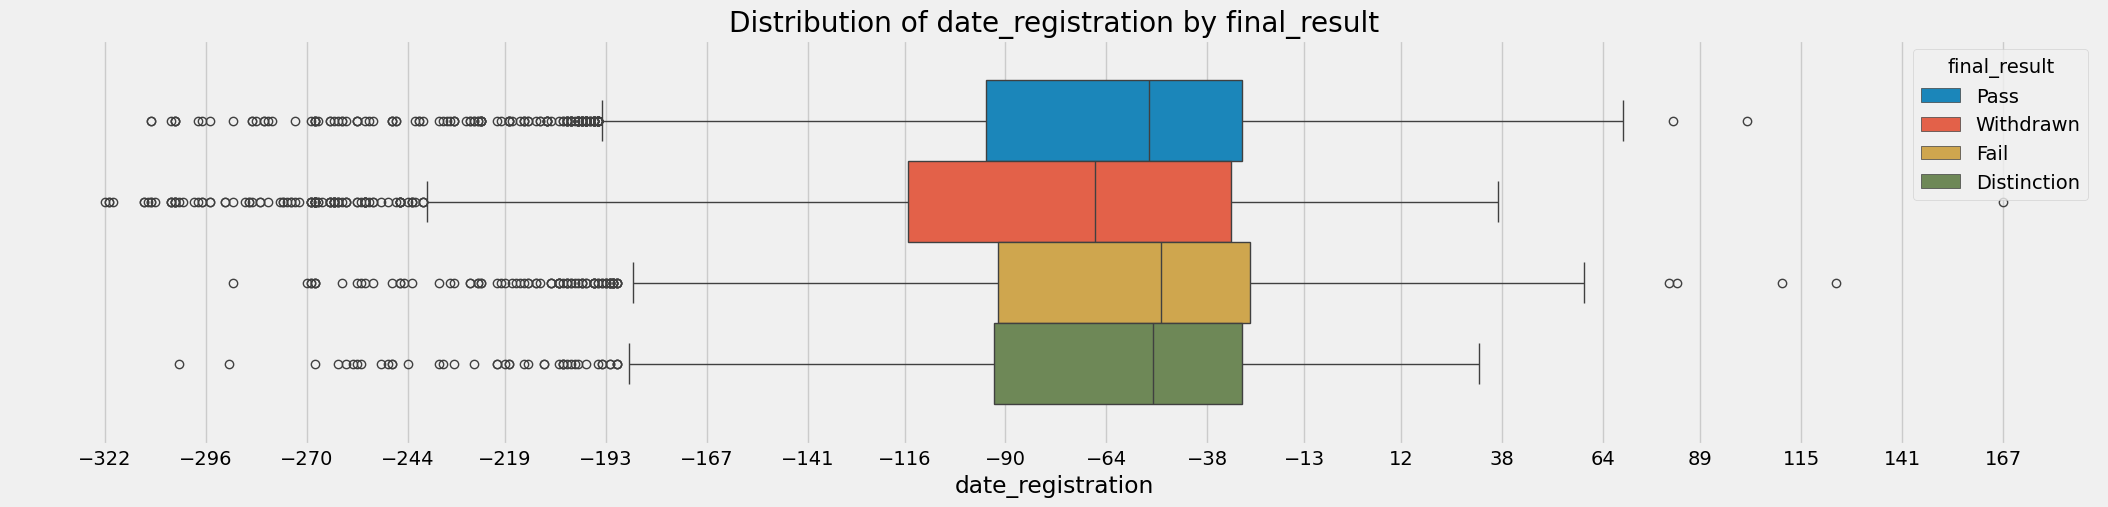

In [48]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='date_registration',data= data,target='final_result')

In [49]:
data.groupby('final_result')['date_registration'].mean().round(2)

final_result
Distinction   -65.64
Fail          -62.81
Pass          -66.71
Withdrawn     -78.35
Name: date_registration, dtype: float64

**Withdrawn candidates ae showing less mean for date_registration**

In [50]:
S.numerical_test(data,'final_result','date_registration','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: weak


**groups are different in both withdrawn and not withdrawn class, with a weak realtionship**

***

**total_vle_used**

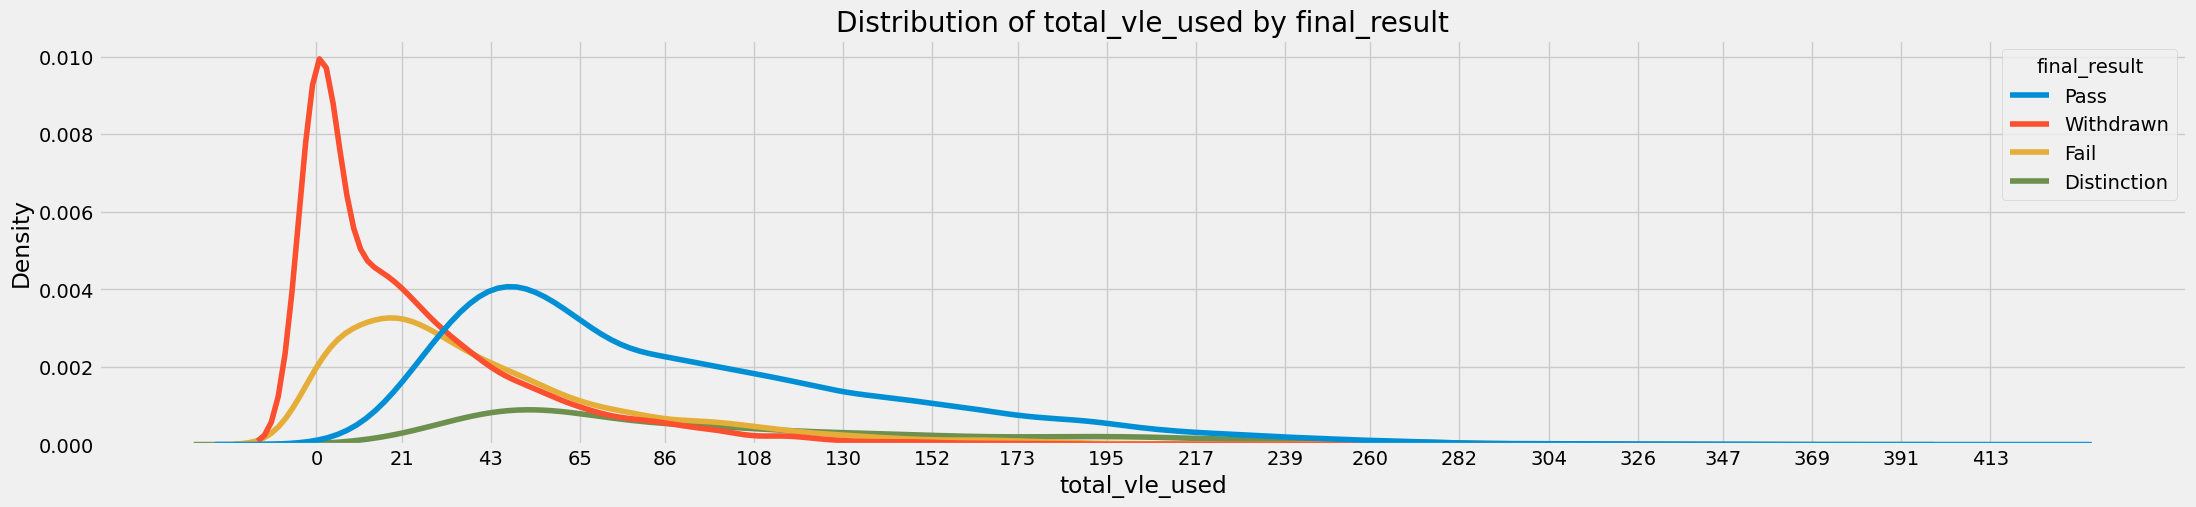

In [51]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='total_vle_used',data= data,target='final_result')

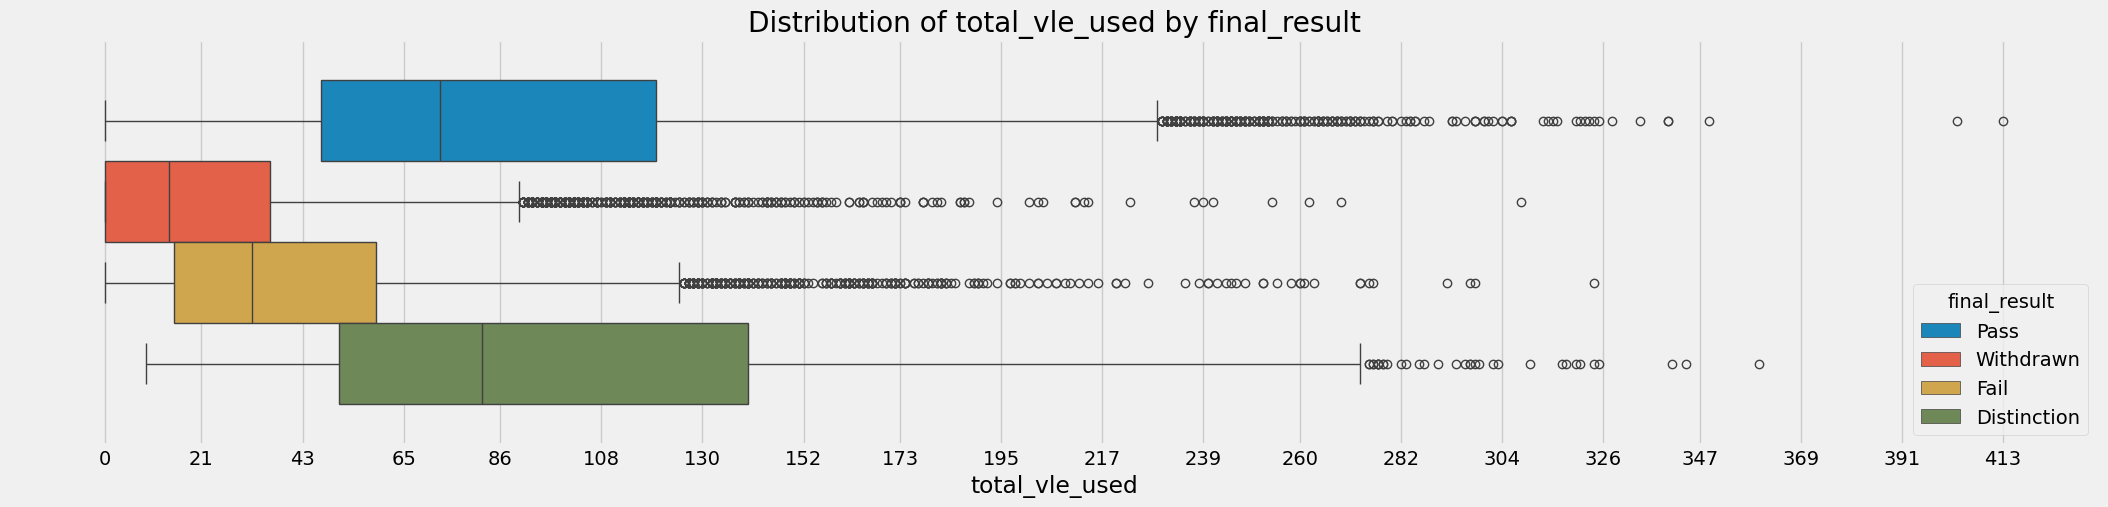

In [52]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='total_vle_used',data= data,target='final_result')

In [53]:
data.groupby('final_result')['total_vle_used'].mean().round(2)

final_result
Distinction    102.45
Fail            43.08
Pass            89.06
Withdrawn       24.23
Name: total_vle_used, dtype: float64

**for withdrawn class, total_vle_used is showing the least mean value**

In [54]:
S.numerical_test(data,'final_result','total_vle_used','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: strong


**groups are different in total_vle_used column, with a strong relationship**

***

**total_clicks**

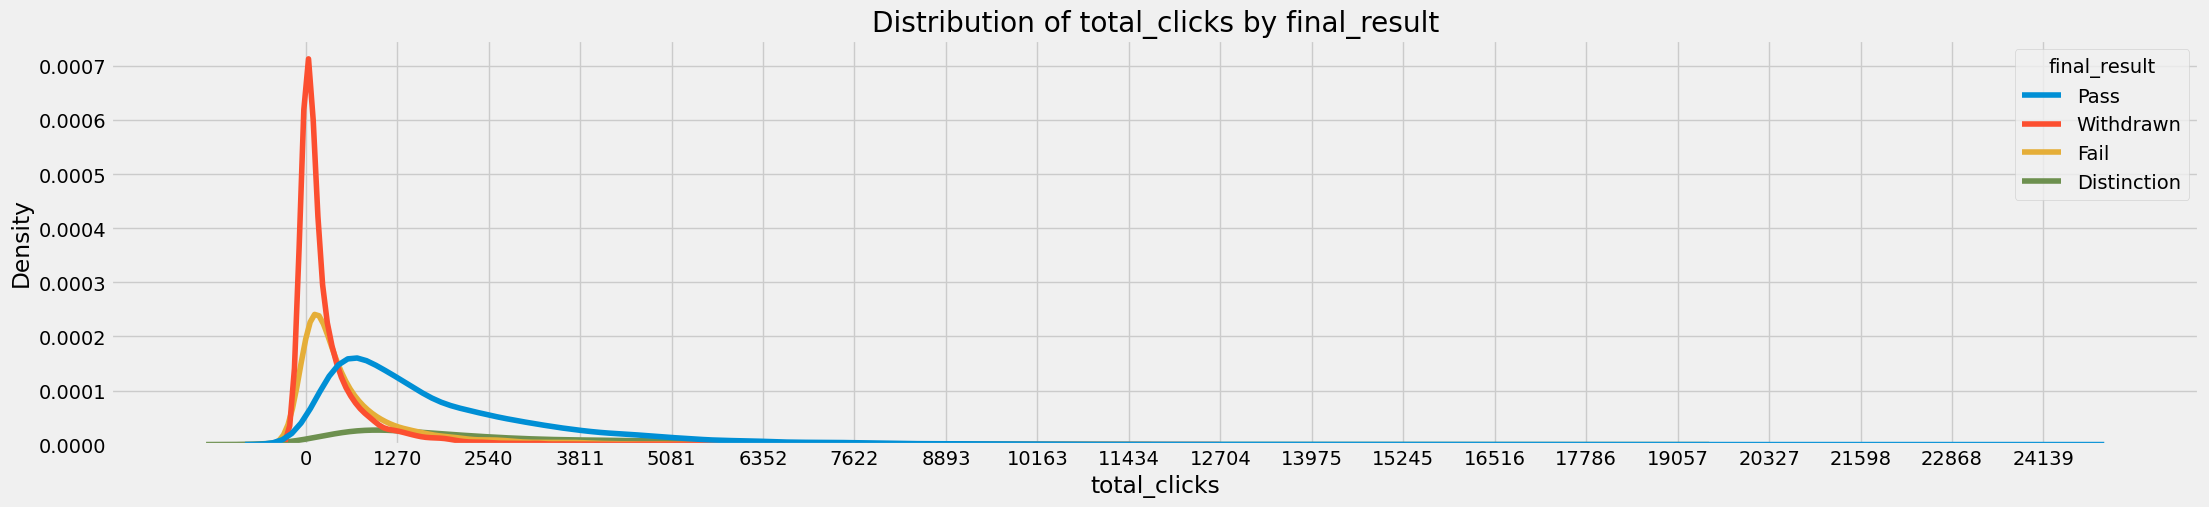

In [55]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='total_clicks',data= data,target='final_result')

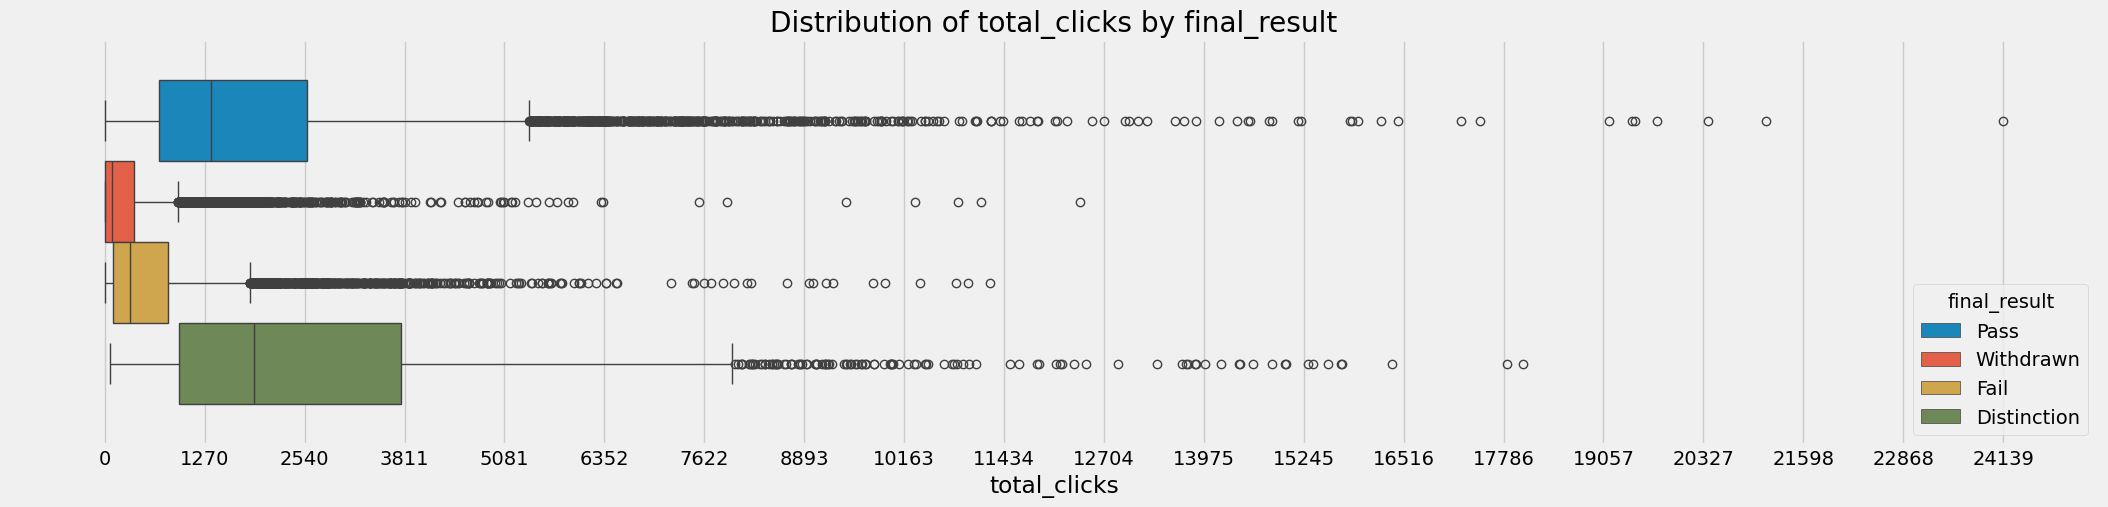

In [56]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='total_clicks',data= data,target='final_result')

In [57]:
data.groupby('final_result')['total_clicks'].mean().round(2)

final_result
Distinction    2666.76
Fail            651.85
Pass           1921.81
Withdrawn       313.95
Name: total_clicks, dtype: float64

**for withdrawn class, average total mean is the lowest**

In [58]:
S.numerical_test(data,'final_result','total_clicks','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: strong


**groups are different for total_clicks column, with strong relationship**

***

**total_assessments**

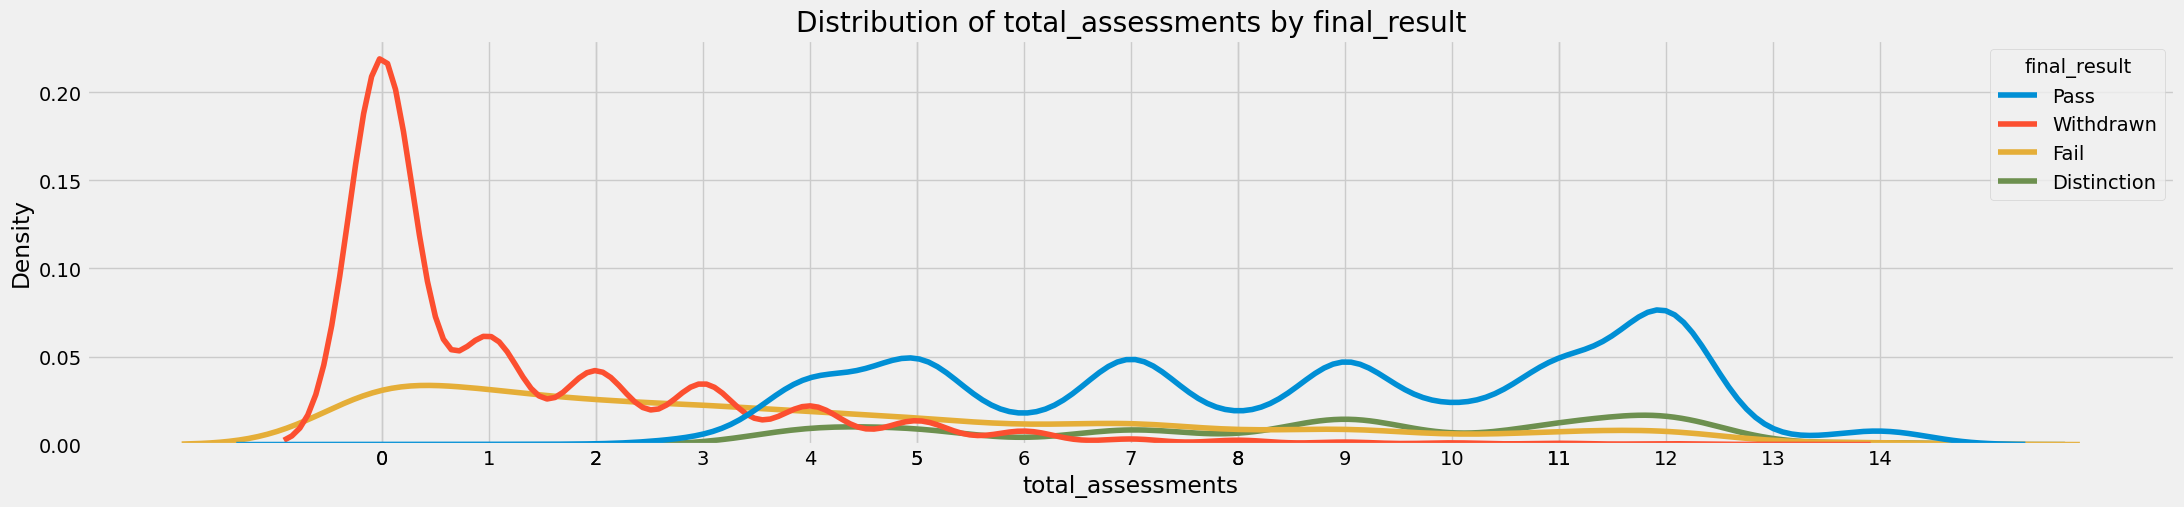

In [59]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='total_assessments',data= data,target='final_result')

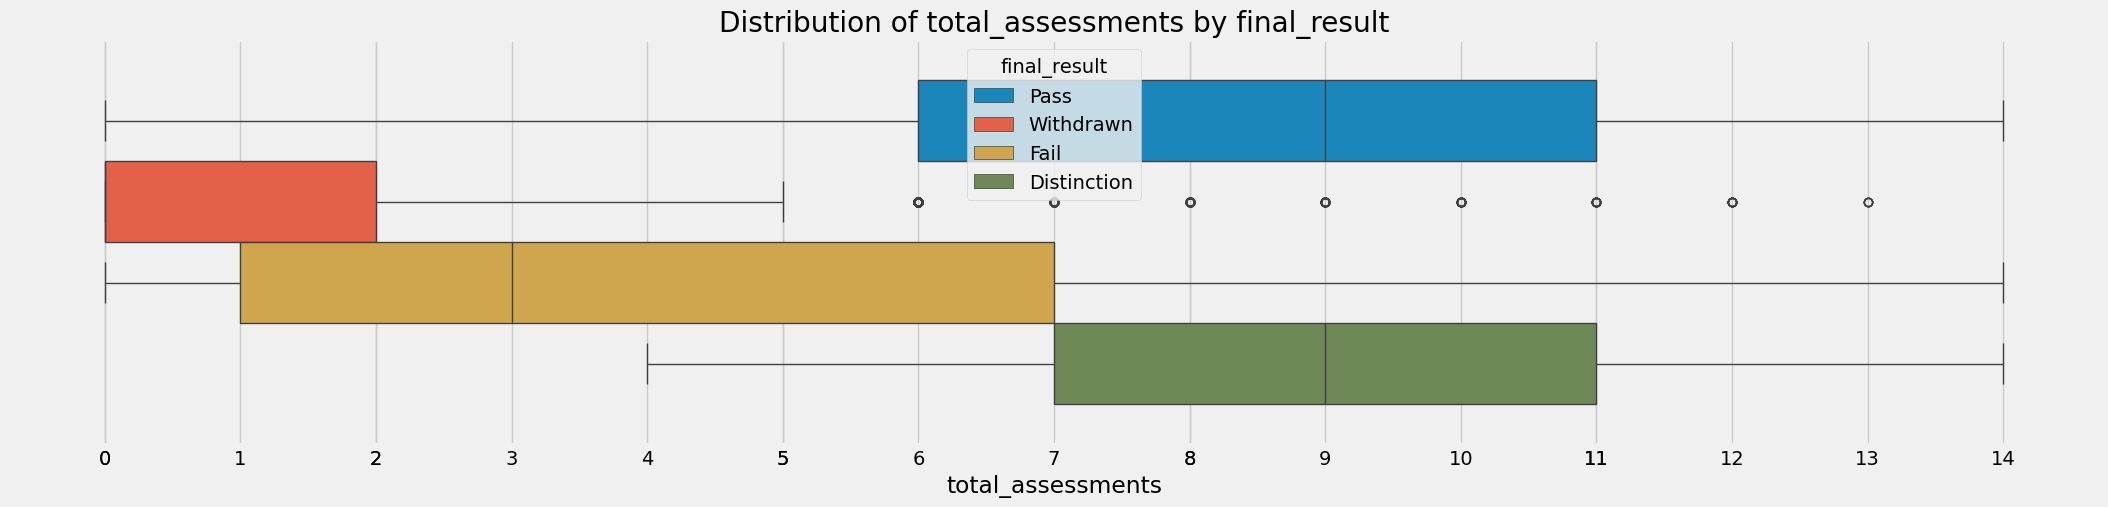

In [60]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='total_assessments',data= data,target='final_result')

In [61]:
data.groupby('final_result')['total_assessments'].mean().round(2)

final_result
Distinction    8.71
Fail           4.04
Pass           8.58
Withdrawn      1.29
Name: total_assessments, dtype: Float64

**mean value for total_assessments is least for withdrawn candidates**

In [62]:
S.numerical_test(data,'final_result','total_assessments','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: strong


**groups are different for total_assessments class, with strong relationship**

***

**attempted_assessments**

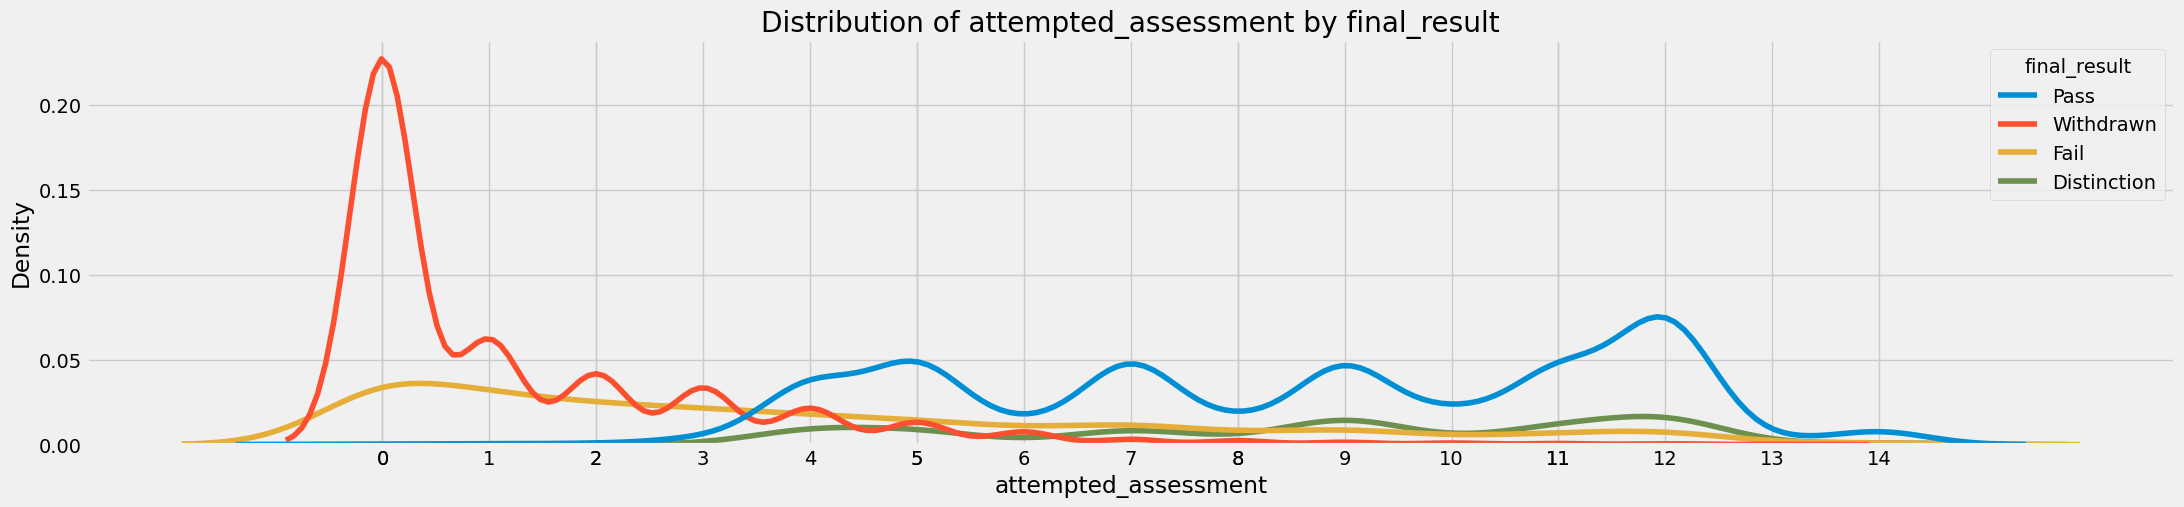

In [63]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='attempted_assessment',data= data,target='final_result')

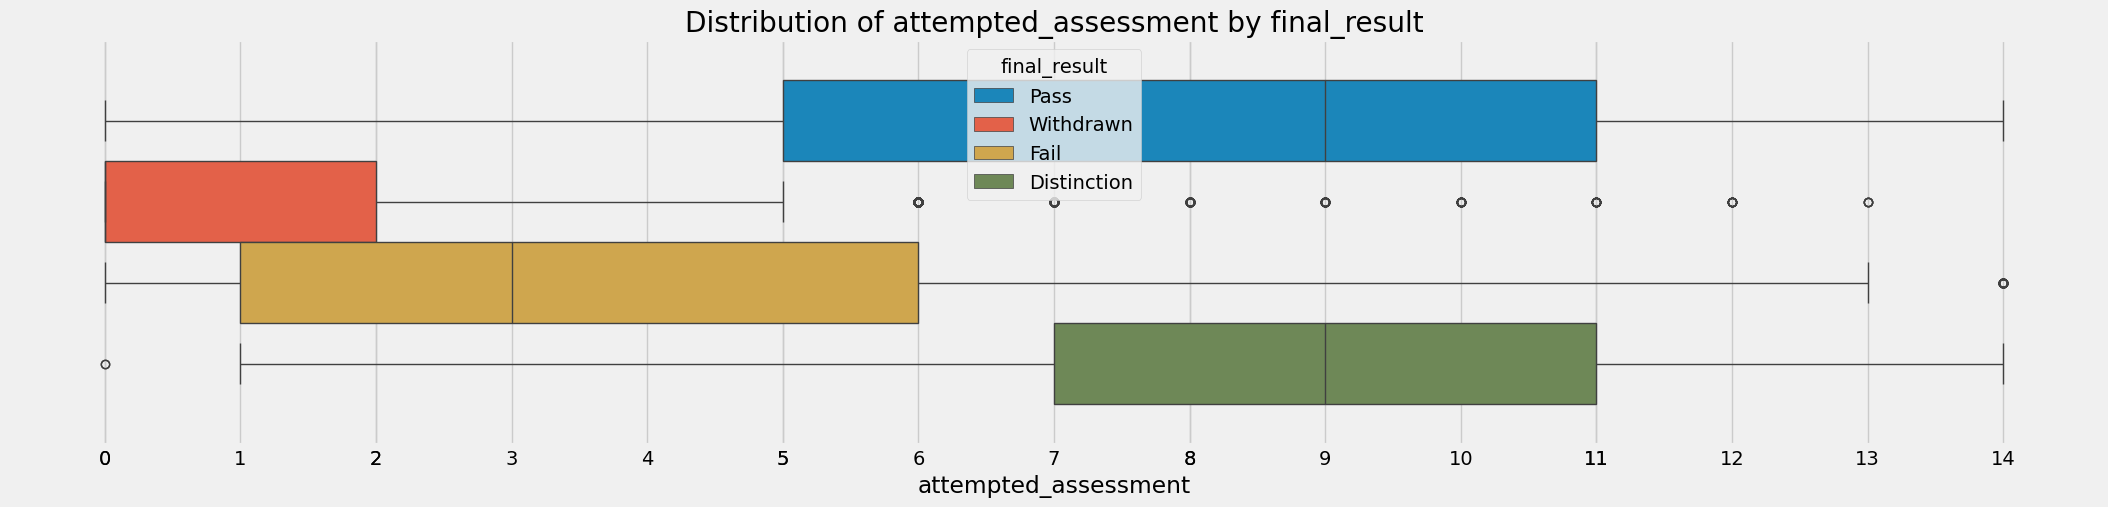

In [64]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='attempted_assessment',data= data,target='final_result')

In [65]:
data.groupby('final_result')['attempted_assessment'].mean().round(2)

final_result
Distinction    8.68
Fail           3.92
Pass           8.53
Withdrawn      1.25
Name: attempted_assessment, dtype: Float64

**mean of total_attempted_assessment is lowest for withdrawn class**

In [66]:
S.numerical_test(data,'final_result','attempted_assessment','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: strong


**attempted assessments groups for withdrawn class is different, with strong relationship**

***

**non_attempted_assessments**

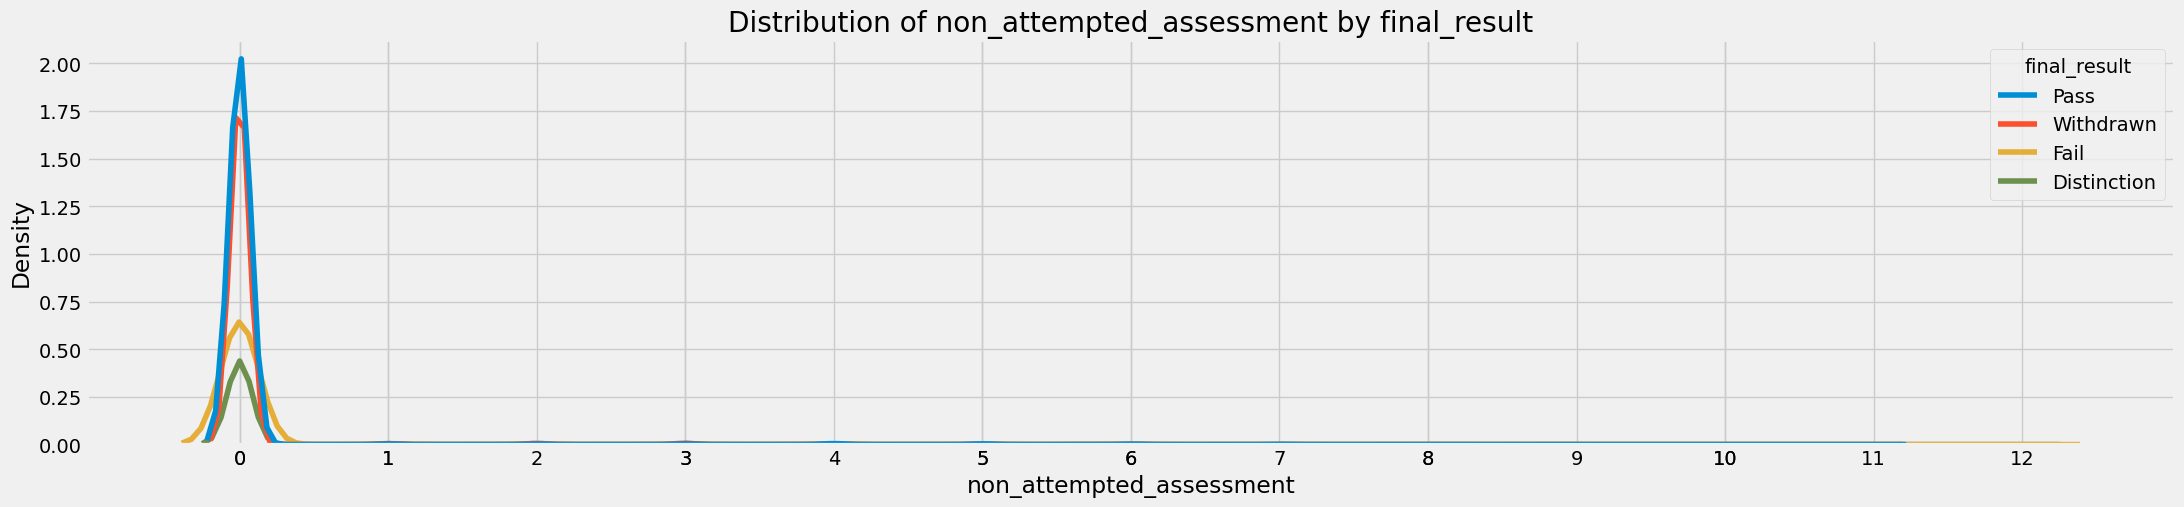

In [67]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='non_attempted_assessment',data= data,target='final_result')

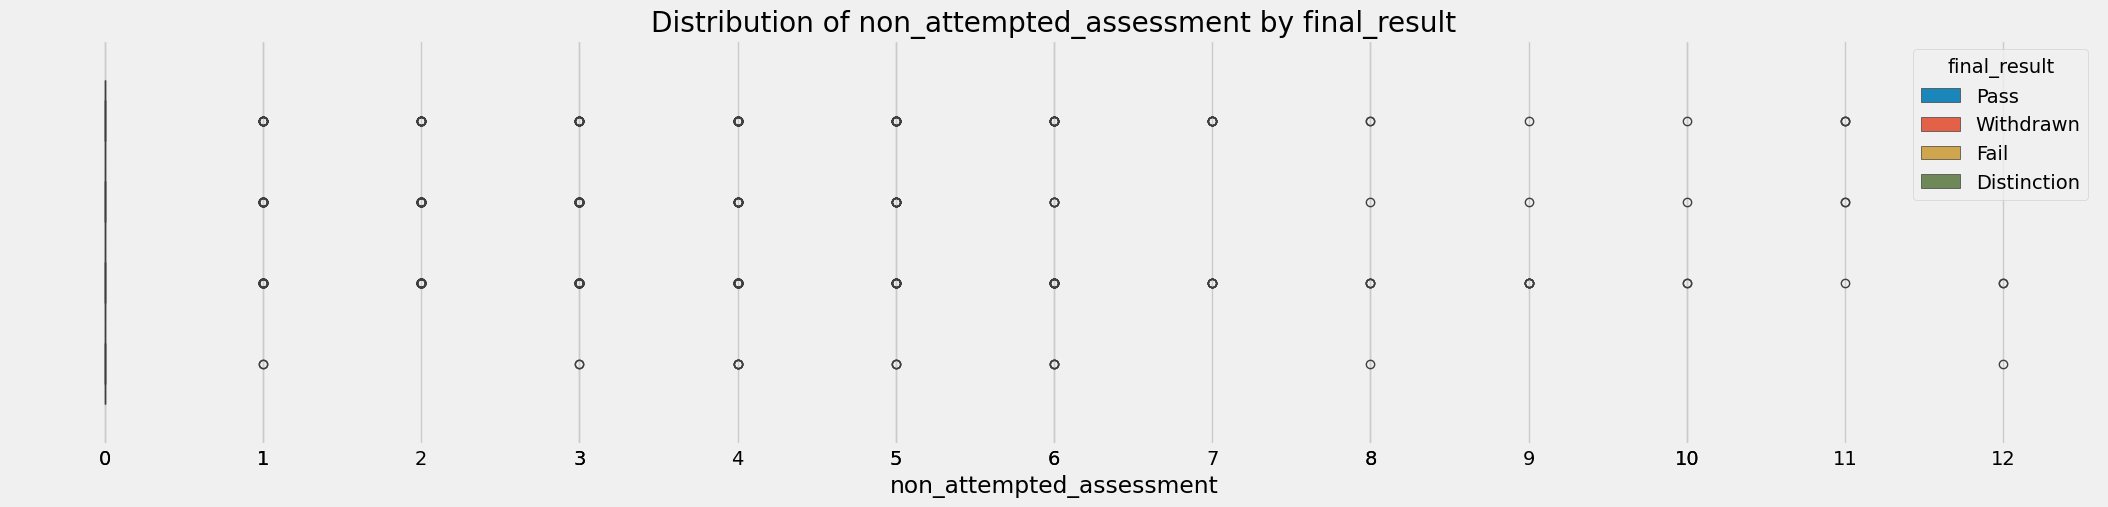

In [68]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='non_attempted_assessment',data= data,target='final_result')

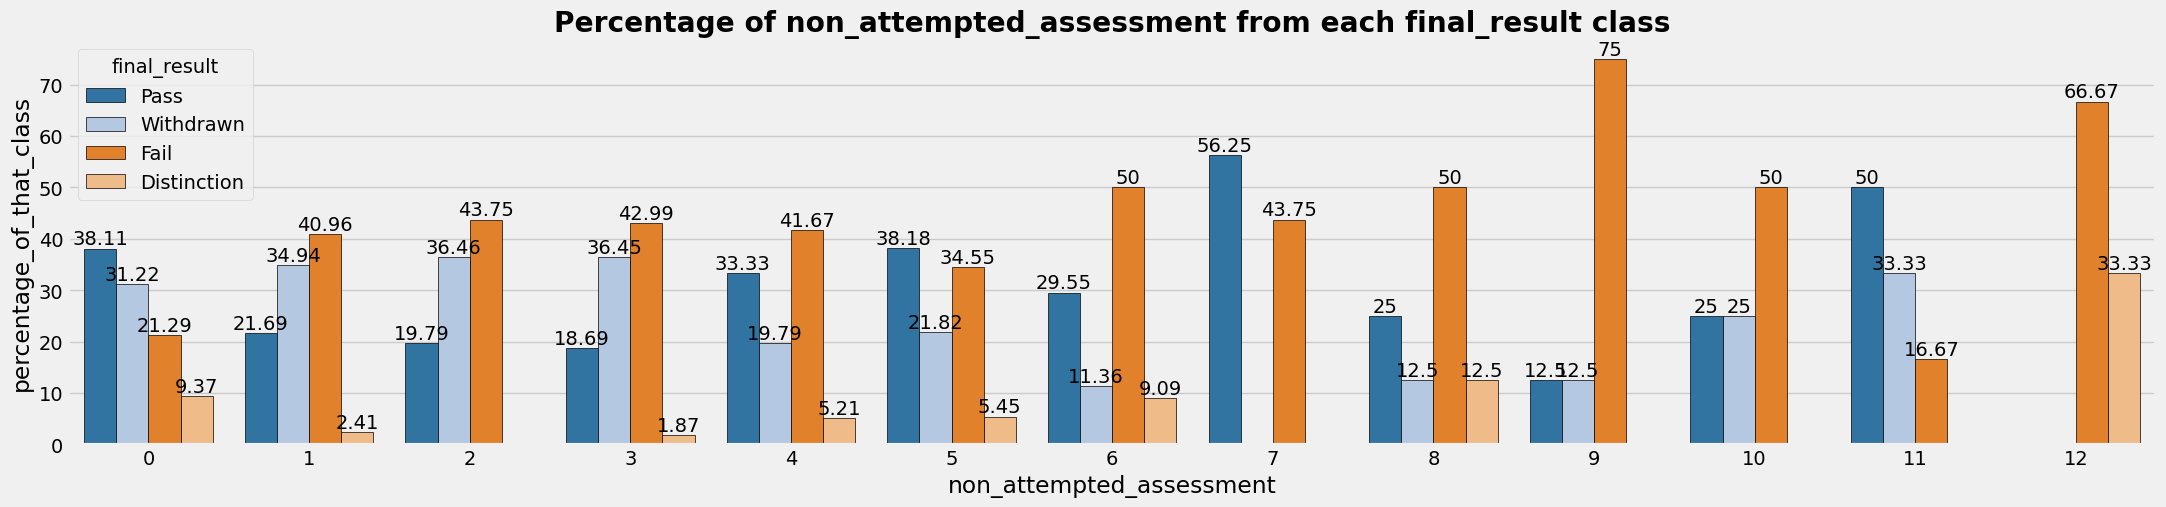

In [69]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='non_attempted_assessment',data=data,target='final_result',orient='v')

In [70]:
data.groupby('final_result')['non_attempted_assessment'].mean().round(2)

final_result
Distinction    0.03
Fail           0.12
Pass           0.05
Withdrawn      0.04
Name: non_attempted_assessment, dtype: Float64

**did not find any particular relationship**

***

**average_score**

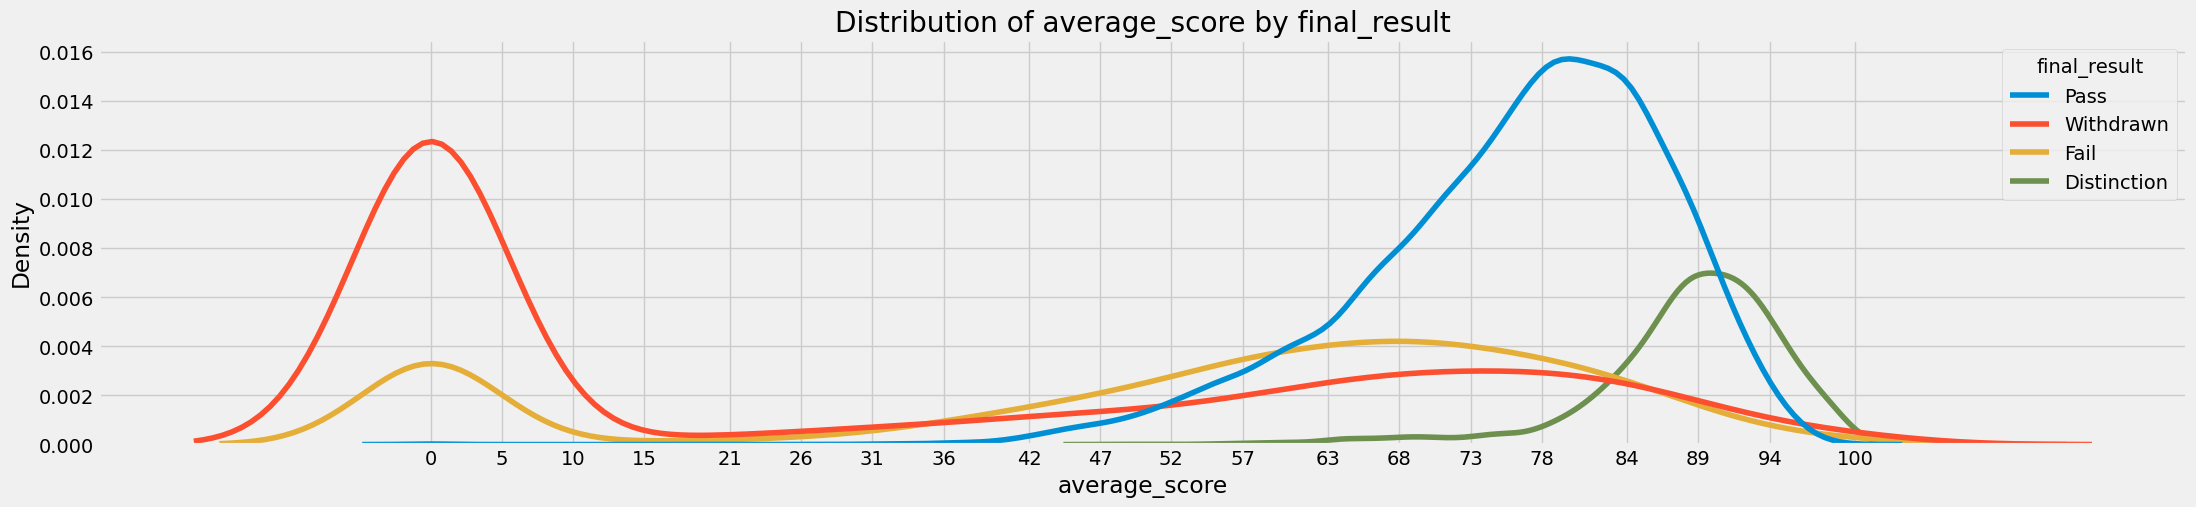

In [71]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='average_score',data= data,target='final_result')

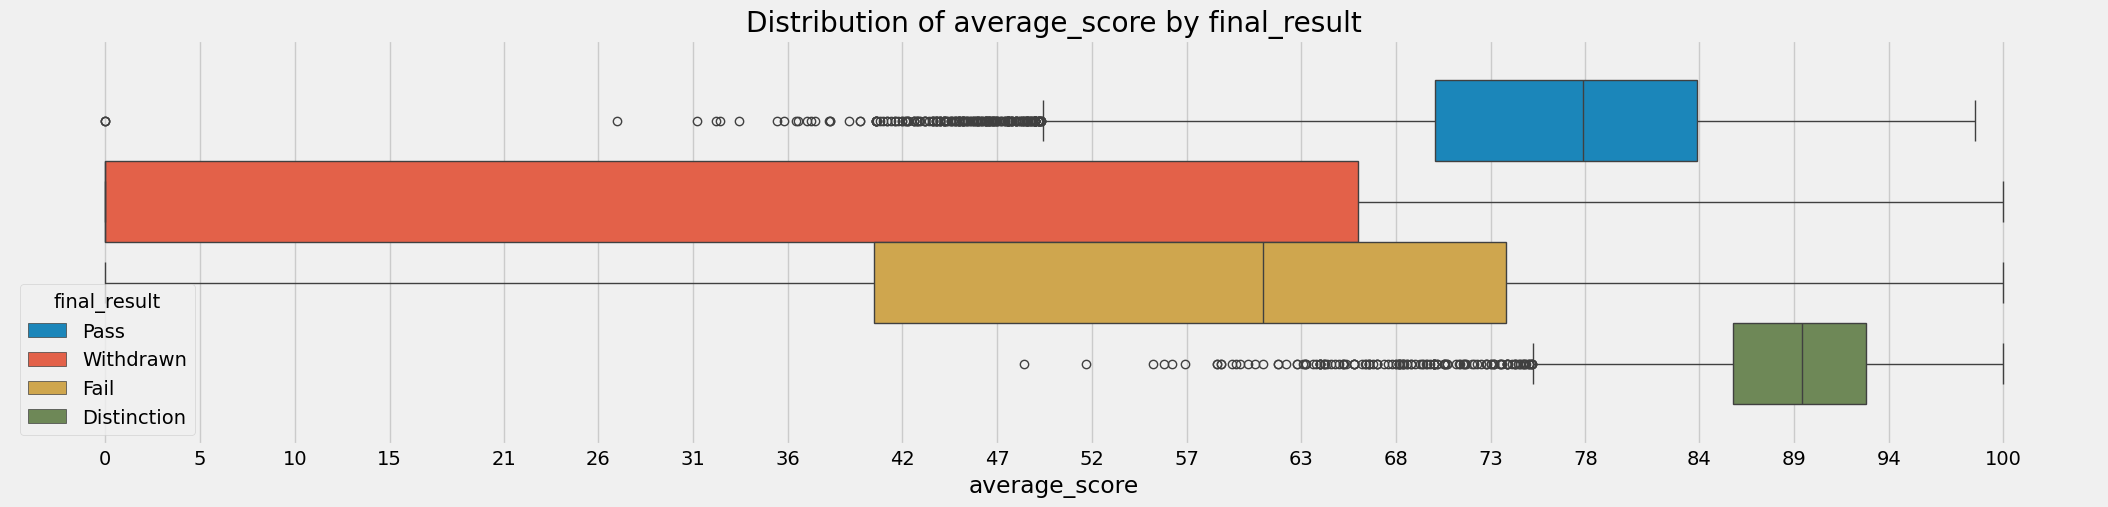

In [72]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='average_score',data= data,target='final_result')

In [73]:
data.groupby('final_result')['average_score'].mean().round(2)

final_result
Distinction    88.49
Fail           52.51
Pass           76.16
Withdrawn      29.50
Name: average_score, dtype: float64

**mean value of average score in withdrawn class is the least**

In [74]:
S.numerical_test(data,'final_result','average_score','Withdrawn')

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: strong


**groups are different for withdrawn class, with strong relationship**

***

### ***Findings from bivariate analysis with target column***

***Categorical with final_result***

- `CCC` value in code_module is showing high percentage of withdrawn observations, after doing statistical analysis we can validate that `code_module` have weak relationship with final result column

- `no fromal quals` value in highest_education is showing high percentage of withdrawn observations, after doing statistical test we can validate a moderate relationship with `final_result`

- `imd_band` is showing a relationship, smaller the imd_band more the withdrawn observation, but after doing statistical analysis we can see that there is a weak relationship between `imd_band` and `final_result` column

- `age_band` is showing higher the `age_band` less the chance of withdrawn, but after doing statistical test we see that the relationship is weak

- `Y` in `disability` is showing high percentage of withdrawn, after doing statistical test, we can validate that there is weak relationship between `disability` and `final_result`

***Numerical with final_result***

- for `withdrawn` category `studied_credits` column have high mean compared to other categories, after doing statistical test we can validate that students who used high credits are more likely to withdraw but the strength of relationship is weak

- `num_of_previous_attempt` is showing relatively high percentage of withdrawn for value 6 but the relationship is weak

- `date_registration` is showing early registration have higher withdrawn with a weak relationship

- `total_vle_used` is showing that less vle usage leads to higher withdrawn, with a strong relationship

 - `total_click` is showing for withdrawn category average total_click is lowest, with a strong relationship

- `total_assessments` is showing for withdrawn category average total_assessments is lowest, with a strong relationship

- `attempted_assessment` is showing less the value is higher the chance of withdrawn, with a strong relationship

- `average_score` is showing low score leads to high withdrawn value, with a strong relationship